<a href="https://colab.research.google.com/github/jjiguaran/series_de_tiempo/blob/master/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explanation
## Prophet

![Image for post](https://miro.medium.com/max/2135/1*ATWC39w-KtmvU_mNDWNxLw.png)

Prophet es un procedimiento para pronosticar datos de series de tiempo basado en un modelo aditivo donde las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria, más los efectos de las vacaciones. Funciona mejor con series de tiempo que tienen fuertes efectos estacionales y varias temporadas de datos históricos. Prophet es robusto ante los datos faltantes y los cambios de tendencia, y normalmente maneja bien los valores atípicos.

Según el artículo de Facebook, Prophet usa un modelo aditivo:

y(t)=g(t)+s(t)+h(t)+ϵt

Dónde:

**g (t)** es la función de tendencia que modela cambios no periódicos usando un modelo de crecimiento de saturación no lineal o un modelo de regresión lineal por partes. Puede configurar esto usando parámetros.

**s (t)** es el funcional estacional (anual, semanal y diario) que modela los cambios periódicos en el valor de la serie temporal. Este componente se modela mediante una transformada de Fourier y, si lo desea, puede agregar sus propias estacionalidades.

**h (t)** representa la función para modelar días festivos y eventos de impacto especial. Puede agregar su propio conjunto de feriados personalizados y eventos especiales.

**εt** es el error / ruido de los modelos que se supone que tiene una distribución normal

 Nuestros datos son mensuales, por lo que no podemos modelar con días festivos.

La sintaxis es similar a scikit-learn con llamadas a las funciones de ajuste y predicción. Necesitamos crear un nuevo marco de datos para pronosticar a través de la función make_future_dataframe. El parámetro freq controla la frecuencia (por ejemplo, "D" para días, "M" para meses).

Prophet espera que las columnas tengan nombres específicos, `ds`para la parte temporal y `y`para la parte de valor. Así que nos adherimos a eso.

La _columna yhat_ contiene las predicciones y luego tiene las bandas superior e inferior de las predicciones. Aunque el marco de datos de pronóstico contiene todos los datos que necesita para hacer sus propios gráficos, Prophet también proporciona métodos prácticos para el trazado. En aras de la brevedad, utilizaremos los métodos incorporados donde podamos, pero cuando sea necesario, haremos nuestros propios gráficos personalizados con plotly. Trazar nuestro pronóstico con Prophet se puede hacer así:

Esta trama del Prophet no contiene todos los puntos de cambio, solo los más importantes. Si desea verlos todos, puede usar el siguiente código:

**Observaciones:**

-   Especificamos ajustar el `yearly_seasonality`con la opción _automática_ para los modos de Fourier.
-   Pedimos el 0,95 en `interval_with`lugar del predeterminado (0,8).
-   Incluimos la `mcmc_samples`opción de obtener incertidumbre en la estacionalidad (mediante muestreo bayesiano).

Esto podría indicar un posible sobreajuste. En una segunda iteración, se podría modificar `prior_scale`en la definición del modelo para agregar más regularización. 

### Opciones de incertidumbre / Opciones de tendencia / Opciones de vacaciones

Hay opciones para controlar la incertidumbre, la tendencia (tipo (o modo), el punto de cambio y la visualización) y el efecto de las vacaciones (país o entrada del usuario). He aquí un resumen: 
![Imagen para publicación](https://miro.medium.com/max/1615/1*ZKYf5HQQSA3K2VAlTb1eDQ.png)

Hay muchas opciones en Prophet para controlar la estacionalidad. Estacionalidad anual, semanal y diaria y su granularidad; modo de estacionalidad (aditivo / multiplicativo); estacionalidad definida por el usuario, incluida la estacionalidad condicional.


![Imagen para publicación](https://miro.medium.com/max/1628/1*G_pFdUpeL5UIA6NMBXVV_g.png)


https://medium.com/swlh/facebook-prophet-426421f7e331



## Puntos de cambio de tendencia
La tendencia en una serie en tiempo real puede cambiar abruptamente. Prophet intenta detectar estos cambios automáticamente usando un previo laplaciano o doble exponencial. De forma predeterminada, los puntos de cambio solo se ajustan para el primer 80% de la serie temporal, lo que permite una pista suficiente para el pronóstico real. 

Para ajustar el cambio de tendencia, podemos usar el parámetro changepoint_prior_scale que está configurado en 0.05 por defecto. Aumentar su valor haría que la tendencia fuera más flexible y reduciría el desajuste, con el riesgo de sobreajuste. Fijémoslo en 0.5 como sugiere la Guía de documentación de Prophet. Si queremos generar intervalos de incertidumbre para los componentes de tendencia y estacionalidad, necesitamos realizar un muestreo bayesiano completo, lo que se puede hacer utilizando el parámetro mcmc_samples en Prophet.

## Plot model components

El usuario también puede definir manualmente los puntos de cambio en función del conocimiento del dominio (por ejemplo, al pronosticar las ventas, el analista puede estar al tanto de lanzamientos de nuevos productos, ventas, etc.). Usando la función plot_components podemos mostrar los componentes del modelo:

Observamos una tendencia lineal por partes. Prophet también tiene la capacidad de adaptarse a las tendencias de saturación utilizando un modelo de tendencia de crecimiento logístico. Esto es aplicable en casos donde la tendencia está limitada por la capacidad, p. Ej. el número de usuarios de Facebook en un país estaría naturalmente limitado por el número de personas con acceso a Internet. Esto se hace configurando el parámetro growth = logistic y definiendo una columna llamada cap en el marco de datos.

## Cross validation
Podemos realizar una validación cruzada para medir el error de pronóstico. Se seleccionan los puntos de corte y entrenamos el modelo con los datos hasta ese punto. Luego, podemos comparar la predicción con los datos reales en un horizonte de tiempo específico. Esto se puede hacer usando la función cross_validation. El período del parámetro especifica el intervalo entre los puntos de corte.

La biblioteca Prophet hace posible dividir nuestros datos históricos en datos de entrenamiento y datos de prueba para la validación cruzada. Los principales conceptos para la validación cruzada con Prophet son:

-   **Datos de entrenamiento (inicial)** : la cantidad de datos reservados para el entrenamiento. El parámetro está en la API llamado initial.
-   **Horizonte** : Los datos reservados para validación. Si no define un período, el modelo se ajustará a Horizon / 2.
-   **Cutoff (período)** : se realiza una previsión para cada punto observado entre el corte y el corte + horizonte.

El marco de datos resultante ahora se puede utilizar para calcular medidas de error de _yhat -  y_ . A continuación, he trazado un gráfico con algunos marcadores para ayudarlo a comprender de una manera más visual. 

La salida de cross_validation es un marco de datos con los valores reales y y los valores de pronóstico fuera de la muestra `yhat`, en cada fecha de pronóstico simulada y para cada fecha de corte. En particular, se hace un pronóstico para cada punto observado entre `cutoff`y `cutoff + horizon`. Este marco de datos se puede utilizar para calcular medidas de error de yhat frente a y.

Así que ahora hemos hecho nuestro primer pronóstico con la biblioteca Prophet. Pero, ¿cómo sabemos si los resultados son buenos? Afortunadamente, Prophet viene con algunas métricas de rendimiento integradas que pueden ayudarnos. No voy a entrar en detalles cuando se trata de qué métricas usar y eso lo dejo a usted. Las métricas de rendimiento disponibles son:

-   **Mse** : error absoluto medio
-   **Rmse** : error cuadrático medio
-   **Mae** : error medio medio
-   **Mape** : error porcentual medio medio
-   **Mdape** : error porcentual medio promedio

El código para validar y recopilar métricas de rendimiento se muestra a continuación. Primero necesita obtener los datos de validación cruzada (ya lo hicimos en la lista de códigos anterior, es el marco de datos llamado `cv_df`) Luego, colocamos el marco de datos de validación cruzada en el método Prophet `perfomance_metrics`, así:

## Add regressor

Los regresores adicionales pueden ser discretos como las vacaciones futuras u otra serie temporal. Sin embargo, esta serie temporal debe conocerse o preverse por separado para fechas futuras.

Tenga en cuenta que no siempre es posible predecir estos parámetros por adelantado; este regresor adicional también se puede pronosticar, con un error de pronóstico asociado.

Agregar regresores adicionales es bastante sencillo, pero recuerde que si va a usar algunos en su modelo de pronóstico, debe tener los datos presentes de antemano. Con datos meteorológicos, esto se puede lograr con pronósticos meteorológicos. En mi humilde opinión, los regresores adicionales más fáciles y sólidos que puedes usar son los días festivos y las fechas especiales que conoces, así que te animo a que trabajes un poco más en ellos. Pero volvamos a los datos meteorológicos.

Prophet tiene varias formas de agregar días festivos y eventos especiales. El más fácil y conveniente es utilizar los días festivos nacionales integrados. Las vacaciones para cada país las proporciona el paquete de vacaciones en Python. Una lista de países disponibles y el nombre del país que se utilizará está disponible en su página: [https://github.com/dr-prodigy/python-holidays]

```
# List the holiday names
m.train_holiday_names
```

La última línea de código enumera todos los días festivos incorporados y, por lo que parece, la lista parece ser correcta, aunque podría aumentarse con fechas para Nochebuena o Nochevieja y tal vez otras, pero es un comienzo. Si queremos ver el pronóstico y los efectos que hacen los regresores de vacaciones podemos trazarlo así:

## Hiperparametros
Prophet tiene bastantes parámetros para que los sintonices. No voy a profundizar en los detalles de todos ellos, pero a continuación puede ver el código que puede usar para probar diferentes hiperparámetros en un bucle y luego elegir los mejores. Recuerde que si opta por probar todos los parámetros de una vez, el número de permutaciones será elevado y el tiempo de ejecución considerable. Elegí ajustar un parámetro a la vez y dejé las matrices de parámetros con las que comencé en los comentarios para que las probara usted mismo.

## Conclussion
Prophet es fácil e intuitivo de usar y los componentes del modelo son fácilmente explicables. También permite la incorporación del conocimiento del dominio en el modelo, por ejemplo, a través de puntos de cambio conocidos o límites de capacidad. Los pronósticos son bastante decentes, pero en algunos casos, ciertos parámetros deben modificarse en comparación con la configuración predeterminada, lo que se hace fácilmente.


In [ ]:
import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import numpy as np
from fbprophet import Prophet

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
plt.style.use(["default"])
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

In [ ]:
url = 'https://raw.githubusercontent.com/jjiguaran/series_de_tiempo/master/df_variaciones.csv'
url = 'https://raw.githubusercontent.com/jjiguaran/series_de_tiempo/master/df_final.csv'
df = pd.read_csv(url, index_col=0).reset_index()
# df.drop(columns=['PIB' ],inplace=True)
df.head()

,index,Turistas,DEXBZUS,14 a 17 anos,18 a 24 anos,25 a 39 anos,40 a 59 anos,60 anos ou mais,Total,PIB,Ingreso,IPCA,tipo_cambio_a3500,ITCR Brasil,temp_max,temp_min,CEPO,1 y 2 estrellas,3 estrellas,4 estrellas,5 estrellas,Apart,Boutique,Hostel,Otros/resto
0,2012-01-01,88318.57205,1.785035,24.800000,16.400000,7.200000,4.000000,2.000000,7.900000,3.7,1387.000000,0.56,4.319719,149.0,31.8,20.7,1,192.060606,272.380952,372.512821,840.913043,352.800000,525.703704,86.570248,125.100629
1,2012-02-01,59186.46835,1.716800,24.800000,16.400000,7.200000,4.000000,2.000000,7.900000,3.4,1387.000000,0.45,4.347507,155.1,30.0,19.7,1,196.050505,273.111111,375.705128,835.521739,345.232877,509.654321,83.254098,125.132911
2,2012-03-01,59478.95959,1.795300,24.800000,16.400000,7.200000,4.000000,2.000000,7.900000,3.1,1387.000000,0.21,4.355723,145.7,26.6,16.8,1,202.575758,276.619048,399.543210,897.416667,355.794521,525.444444,88.831933,122.917722
3,2012-04-01,70629.60541,1.852248,23.933333,16.166667,7.166667,3.866667,2.066667,7.766667,2.8,1394.666667,0.64,4.396693,139.2,23.3,12.8,1,207.393939,280.174603,388.518519,850.458333,356.100000,510.100000,73.051724,126.974684
4,2012-05-01,67893.16757,1.981023,23.066667,15.933333,7.133333,3.733333,2.133333,7.633333,2.5,1402.333333,0.36,4.449077,129.6,20.6,13.2,1,199.800000,280.300000,387.703704,827.916667,355.945946,497.123457,72.827586,132.605096


In [ ]:
df['month'] = pd.DatetimeIndex(df['index']).month


df['Ingreso'] = df['Ingreso'] / df['DEXBZUS']
df['Cambio'] = df['tipo_cambio_a3500'] / df['DEXBZUS']

for col in ['1 y 2 estrellas', '3 estrellas', '4 estrellas', '5 estrellas', 'Apart','Boutique', 'Hostel', 'Otros/resto']:
    df[col] = df[col] / df['tipo_cambio_a3500']
    df[col] = df[col] / df['Ingreso']
    

# df = pd.concat([df, pd.get_dummies(df['month'])], axis=1)
# df.drop(columns=['month',  'DEXBZUS', 'tipo_cambio_a3500',
#                  '14 a 17 anos', '18 a 24 anos', '25 a 39 anos', '40 a 59 anos', '60 anos ou mais', 
#                  'temp_min',  
#                 '1 y 2 estrellas','4 estrellas', '5 estrellas', 'Apart','Boutique', '3 estrellas', 'Otros/resto' ],inplace=True)
df.head(2)

,index,Turistas,DEXBZUS,14 a 17 anos,18 a 24 anos,25 a 39 anos,40 a 59 anos,60 anos ou mais,Total,PIB,Ingreso,IPCA,tipo_cambio_a3500,ITCR Brasil,temp_max,temp_min,CEPO,1 y 2 estrellas,3 estrellas,4 estrellas,5 estrellas,Apart,Boutique,Hostel,Otros/resto,month,Cambio
0,2012-01-01,88318.57205,1.785035,24.8,16.4,7.2,4.0,2.0,7.9,3.7,777.015577,0.56,4.319719,149.0,31.8,20.7,1,0.057221,0.081151,0.110983,0.250534,0.105110,0.156623,0.025792,0.037271,1,2.419963
1,2012-02-01,59186.46835,1.716800,24.8,16.4,7.2,4.0,2.0,7.9,3.4,807.898416,0.45,4.347507,155.1,30.0,19.7,1,0.055818,0.077758,0.106967,0.237882,0.098291,0.145104,0.023703,0.035627,2,2.532332


In [ ]:
df.corr()

,Turistas,DEXBZUS,14 a 17 anos,18 a 24 anos,25 a 39 anos,40 a 59 anos,60 anos ou mais,Total,PIB,Ingreso,IPCA,tipo_cambio_a3500,ITCR Brasil,temp_max,temp_min,CEPO,1 y 2 estrellas,3 estrellas,4 estrellas,5 estrellas,Apart,Boutique,Hostel,Otros/resto,month,Cambio
Turistas,1.000000,-0.115365,-0.089308,-0.108383,-0.108999,-0.069262,0.008987,-0.101822,0.409960,0.189514,-0.347234,0.191562,0.387373,-0.480519,-0.483909,-0.082832,-0.183894,-0.080340,-0.022897,-0.128668,-0.050011,-0.154201,-0.134739,-0.357568,0.259303,0.220997
DEXBZUS,-0.115365,1.000000,0.786591,0.793393,0.764506,0.771599,0.801124,0.755155,-0.505162,-0.927989,-0.083370,0.773380,-0.387146,-0.000672,0.056683,-0.460914,-0.322231,-0.148369,0.227302,0.749313,0.050765,0.732516,-0.328570,0.003157,0.093978,0.727199
14 a 17 anos,-0.089308,0.786591,1.000000,0.994100,0.990408,0.994040,0.976911,0.993273,-0.399123,-0.586168,-0.369209,0.691948,-0.175245,-0.010973,0.051854,-0.745536,-0.524693,-0.414176,-0.203193,0.381224,-0.322847,0.369455,-0.582046,-0.320528,-0.075421,0.691993
18 a 24 anos,-0.108383,0.793393,0.994100,1.000000,0.994524,0.993657,0.972403,0.996433,-0.441688,-0.606503,-0.375132,0.652830,-0.240413,-0.036116,0.026032,-0.744660,-0.470402,-0.373189,-0.171058,0.377464,-0.290218,0.367859,-0.547624,-0.259944,-0.058711,0.650163
25 a 39 anos,-0.108999,0.764506,0.990408,0.994524,1.000000,0.993657,0.967959,0.998458,-0.422788,-0.580889,-0.380266,0.634001,-0.237334,-0.028554,0.032530,-0.762189,-0.441847,-0.344871,-0.161709,0.360252,-0.272726,0.353032,-0.515270,-0.265380,-0.057999,0.631998
40 a 59 anos,-0.069262,0.771599,0.994040,0.993657,0.993657,1.000000,0.982338,0.995819,-0.362207,-0.566116,-0.394136,0.680662,-0.184320,-0.019330,0.040704,-0.777847,-0.497868,-0.398365,-0.191763,0.360425,-0.313237,0.358542,-0.564482,-0.318790,-0.042632,0.683181
60 anos ou mais,0.008987,0.801124,0.976911,0.972403,0.967959,0.982338,1.000000,0.970834,-0.293926,-0.586369,-0.396511,0.756761,-0.135894,-0.062661,0.001607,-0.787180,-0.536657,-0.414543,-0.166948,0.397116,-0.307996,0.387391,-0.586761,-0.362180,-0.023541,0.759913
Total,-0.101822,0.755155,0.993273,0.996433,0.998458,0.995819,0.970834,1.000000,-0.410961,-0.564646,-0.391342,0.633956,-0.213596,-0.029759,0.031758,-0.764157,-0.463503,-0.367989,-0.185864,0.347564,-0.297042,0.338940,-0.539813,-0.282604,-0.067481,0.634250
PIB,0.409960,-0.505162,-0.399123,-0.441688,-0.422788,-0.362207,-0.293926,-0.410961,1.000000,0.632917,-0.118415,-0.006075,0.706062,0.063977,0.029182,-0.048519,-0.116150,-0.172515,-0.168937,-0.314951,-0.170090,-0.281508,0.028675,-0.474651,-0.050247,0.047494
Ingreso,0.189514,-0.927989,-0.586168,-0.606503,-0.580889,-0.566116,-0.586369,-0.564646,0.632917,1.000000,-0.091572,-0.559837,0.573652,0.030158,-0.019266,0.240866,0.033520,-0.155034,-0.473450,-0.817937,-0.331452,-0.787984,0.060134,-0.284162,-0.145848,-0.486831


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots()

# # Add traces
# fig.add_trace(
#     go.Scatter(x=df['index'], y=df.PIB, name="PIB")
# )


# Add traces
fig.add_trace(
    go.Scatter(x=df['index'], y=df['PIB'])
)

# Add figure title
fig.update_layout(
    template="presentation",
    legend=dict(
        orientation="h",
        yanchor="bottom",   y=1.02,    xanchor="right",    x=1,    
        font=dict(
                family="Georgia",
                size=16),
        bordercolor='white'),
)
fig.show()


In [ ]:
df.columns

Index(['index', 'Turistas', 'DEXBZUS', '14 a 17 anos', '18 a 24 anos', '25 a 39 anos', '40 a 59 anos', '60 anos ou mais', 'Total', 'PIB', 'Ingreso', 'IPCA', 'tipo_cambio_a3500', 'ITCR Brasil', 'temp_max', 'temp_min', 'CEPO', '1 y 2 estrellas', '3 estrellas', '4 estrellas', '5 estrellas', 'Apart', 'Boutique', 'Hostel', 'Otros/resto', 'month', 'Cambio'], dtype='object')

In [ ]:
reg_cols = []
for index, col in enumerate(df.columns[2:]):
    print(col, 'regr'+str(index))
    df['regr'+str(index)] = df[col]
    reg_cols.append('regr'+str(index))

# reg_cols

DEXBZUS regr0
14 a 17 anos regr1
18 a 24 anos regr2
25 a 39 anos regr3
40 a 59 anos regr4
60 anos ou mais regr5
Total regr6
PIB regr7
Ingreso regr8
IPCA regr9
tipo_cambio_a3500 regr10
ITCR Brasil regr11
temp_max regr12
temp_min regr13
CEPO regr14
1 y 2 estrellas regr15
3 estrellas regr16
4 estrellas regr17
5 estrellas regr18
Apart regr19
Boutique regr20
Hostel regr21
Otros/resto regr22
month regr23
Cambio regr24


In [ ]:
# reg_cols = ['regr0', 'regr1', 'regr2', 'regr3', 'regr4', 'regr5']

# month_cols = ['regr13','regr14','regr15','regr16','regr17','regr18',
#               'regr19','regr20','regr21','regr22','regr23','regr24']

In [ ]:
# df['regr1'] = (df['Ingreso'] / df['DEXBZUS']) 
# df['regr2'] = df['temp_min']
# df['regr3'] = df['temp_max']
# df['regr4'] = df['tipo_cambio_a3500']
# df['regr5'] = df['DEXBZUS']

print(df.shape)
df = df.rename(columns={'index': 'ds', 'Turistas': 'y'})
df['ds'] = pd.to_datetime(df['ds'],format='%Y-%m-%d')

# Define threshold date.
threshold_date = pd.to_datetime('2019-02-01')
mask = df['ds'] <= threshold_date

# Split the data and select `ds` and `y` columns.
df_train = df[mask][['ds', 'y']]
df_test = df[~ mask][['ds', 'y']]
print(df_train.shape)
print(df_test.shape)

df_test.head()

(98, 52)
(86, 2)
(12, 2)


,ds,y
86,2019-03-01,61902.99982
87,2019-04-01,59837.00000
88,2019-05-01,69763.00000
89,2019-06-01,74633.00000
90,2019-07-01,103483.00000


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots()

# Add traces
fig.add_trace(
    go.Scatter(x=df_train.ds, y=df_train.y, name="Train")
)

fig.add_trace(
    go.Scatter(x=df_test.ds, y=df_test.y, name="Test", mode='lines')
)

fig.add_trace(go.Scatter(
    x=['2019-02-15','2019-02-15'],
    y=[df_train.y.min(), df_train.y.max()],
    name = 'General Target',
    line=dict(color='grey', width=3, dash='dot'),
    mode = 'lines',
    showlegend=False),
)

# Add figure title
fig.update_layout(
    template="presentation",
    legend=dict(
        orientation="h",
        yanchor="bottom",   y=1.02,    xanchor="right",    x=1,    
        font=dict(
                family="Georgia",
                size=16),
        bordercolor='white'),
)
fig.show()


In [ ]:
# # Split the data and select `ds` and `y` columns.
# df_train = df[mask][['ds', 'y']]
# df_test = df[~ mask][['ds']]

# Time Series Decomposition
We begin the analysis by decomposing the (training) time series into the trend, seasonal and residual components.

In [ ]:
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# from matplotlib import style
# style.use('dark_background')

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_obj = seasonal_decompose(
    x=df_train.set_index('ds'), 
    model='additive'
)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



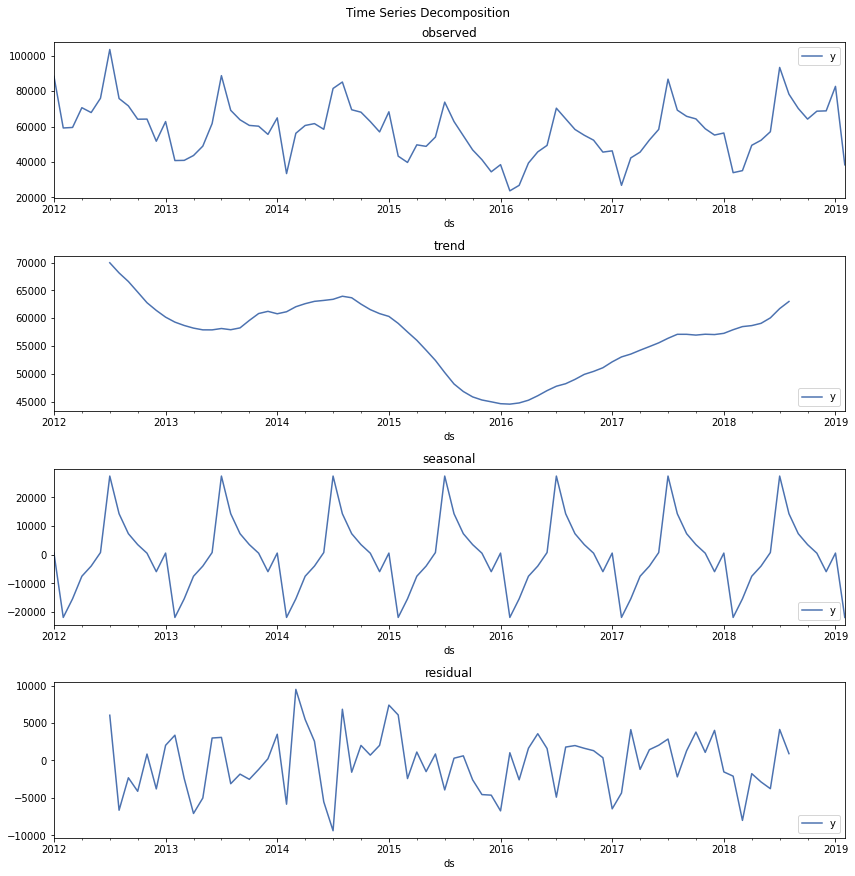

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(12, 12))

# Observed time series.
decomposition_obj.observed.plot(ax=ax[0])
ax[0].set(title='observed')
# Trend component. 
decomposition_obj.trend.plot( ax=ax[1])
ax[1].legend(loc='lower right')
ax[1].set(title='trend')
# Seasonal component. 
decomposition_obj.seasonal.plot( ax=ax[2])
ax[2].legend(loc='lower right')
ax[2].set(title='seasonal')
# Residual.
decomposition_obj.resid.plot( ax=ax[3])
ax[3].legend(loc='lower right')
ax[3].set(title='residual')

fig.suptitle('Time Series Decomposition', y=1.01)
plt.tight_layout()

# Basico prophet additive

In [ ]:
# Fitting a Prophet model
model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False, 
        interval_width=0.95,
        changepoint_prior_scale = 0.5)

# m.add_seasonality(name='monthly', period=12, fourier_order=5)
model.fit(df_train)

# Extend dates and features. 
future = model.make_future_dataframe(periods=df_test.shape[0], freq='M')
# Generate predictions. 
forecast = model.predict(df=future)

In [ ]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
93,2019-09-30,73282.562971,62276.571017,83112.153815,66808.650850,79807.958136,-26.288811,-26.288811,-26.288811,-26.288811,-26.288811,-26.288811,0.0,0.0,0.0,73256.274160
94,2019-10-31,73951.046494,57049.840633,77543.977511,66233.014510,81513.487993,-6655.229816,-6655.229816,-6655.229816,-6655.229816,-6655.229816,-6655.229816,0.0,0.0,0.0,67295.816677
95,2019-11-30,74597.966032,56746.468577,79633.198851,65531.021377,83411.189847,-6337.599484,-6337.599484,-6337.599484,-6337.599484,-6337.599484,-6337.599484,0.0,0.0,0.0,68260.366548
96,2019-12-31,75266.449554,70962.377575,95449.448801,64756.116723,85397.094223,8303.178118,8303.178118,8303.178118,8303.178118,8303.178118,8303.178118,0.0,0.0,0.0,83569.627673
97,2020-01-31,75934.933077,39444.237288,67170.627569,63881.108274,87347.933382,-21985.507356,-21985.507356,-21985.507356,-21985.507356,-21985.507356,-21985.507356,0.0,0.0,0.0,53949.425722


In [ ]:
mask2 = forecast['ds'] <= threshold_date

forecast_train = forecast[mask2]
forecast_test = forecast[~ mask2]

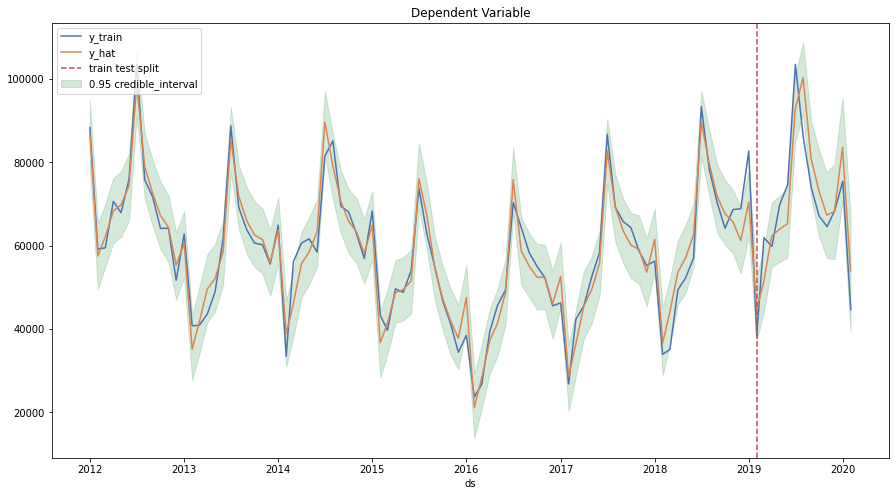

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df, ax=ax)
# sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

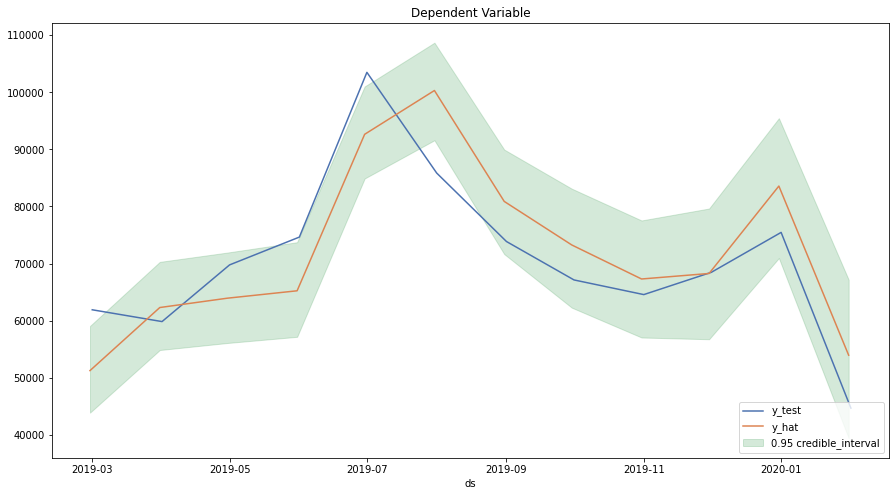

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

ax.fill_between(
    x=forecast_test['ds'],
    y1=forecast_test['yhat_lower'],
    y2=forecast_test['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.legend(loc='lower right')
ax.set(title='Dependent Variable', ylabel='');

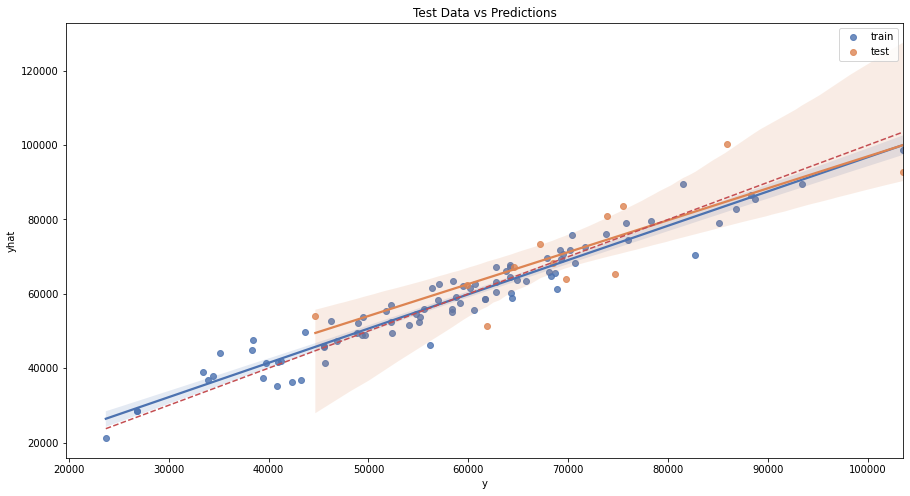

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

# Generate diagonal line to plot. 
d_x = np.linspace(start=df_train['y'].min() - 1, stop=df_train['y'].max() + 1, num=100)

sns.regplot(x=df_train['y'], y=forecast_train['yhat'], color=sns_c[0], label='train', ax=ax)
sns.regplot(x=df_test['y'], y=forecast_test['yhat'], color=sns_c[1], label='test', ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, color=sns_c[3], ax=ax)
ax.lines[2].set_linestyle('--')
ax.set(title='Test Data vs Predictions');

In [ ]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt

print('r2 train: {}'.format(r2_score(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('r2 test: {}'.format(r2_score(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('---'*10)
print('mae train: {}'.format(mean_absolute_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mae test: {}'.format(mean_absolute_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('mape train: {}'.format(mean_absolute_percentage_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mape test: {}'.format(mean_absolute_percentage_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))


print('RMSE train: {}'.format(sqrt(mean_squared_error(y_true=df_train['y'], y_pred=forecast_train['yhat']))))
print('RMSE test: {}'.format(sqrt(mean_squared_error(y_true=df_test['y'], y_pred=forecast_test['yhat']))))

r2 train: 0.9325767295332394
r2 test: 0.6427924822037459
------------------------------
mae train: 3217.785350332825
mae test: 7259.82463449191
mape train: 5.997437143624829
mape test: 10.354471351942909
RMSE train: 4045.305626386222
RMSE test: 8239.457074148193


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.



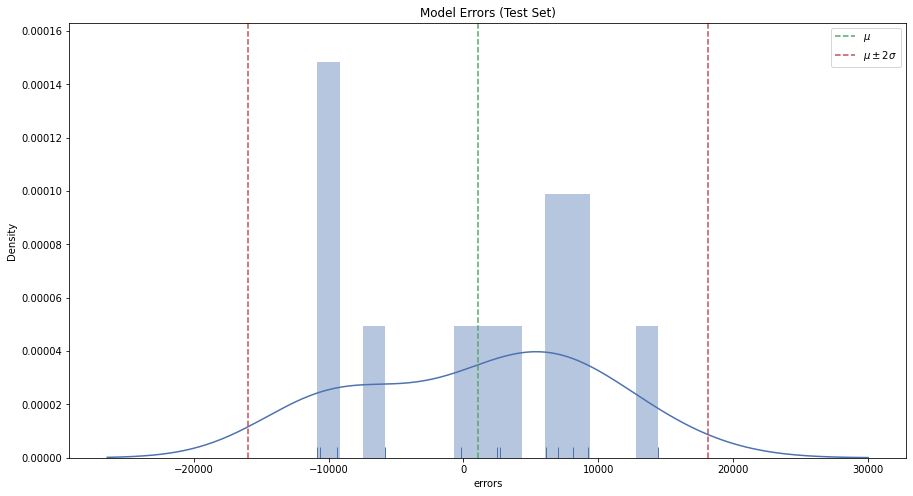

In [ ]:
forecast_test.loc[:, 'errors'] = forecast_test.loc[:, 'yhat'] - df_test.loc[:, 'y']

errors_mean = forecast_test['errors'].mean()
errors_std = forecast_test['errors'].std()

fig, ax = plt.subplots(figsize=(15,8))

sns.distplot(a=forecast_test['errors'], ax=ax, bins=15, rug=True)
ax.axvline(x=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$')
ax.axvline(x=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axvline(x=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

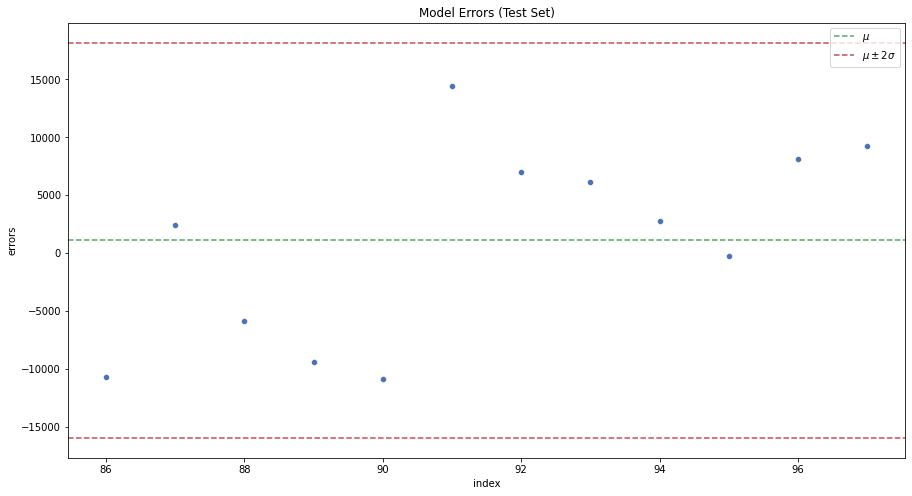

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

sns.scatterplot(x='index', y='errors', data=forecast_test.reset_index(), ax=ax)
ax.axhline(y=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$ ')
ax.axhline(y=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axhline(y=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



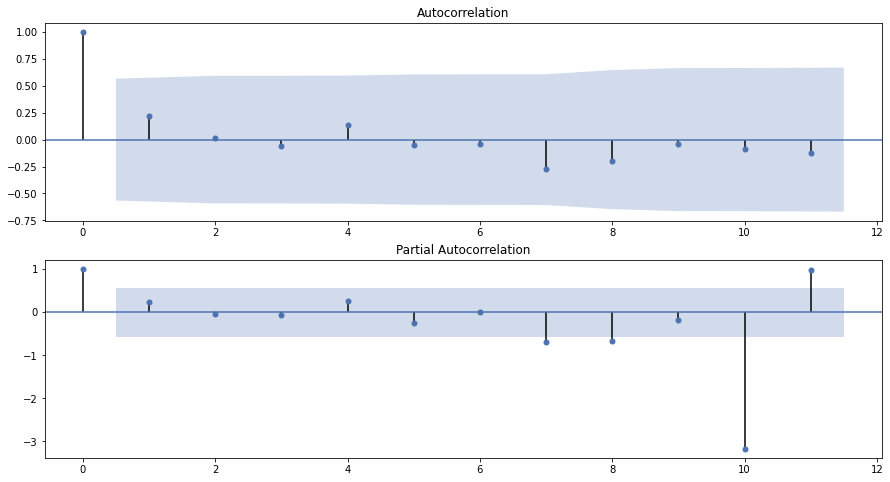

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(15,8))
plot_acf(x=forecast_test['errors'], ax=ax[0])
plot_pacf(x=forecast_test['errors'], ax=ax[1]);

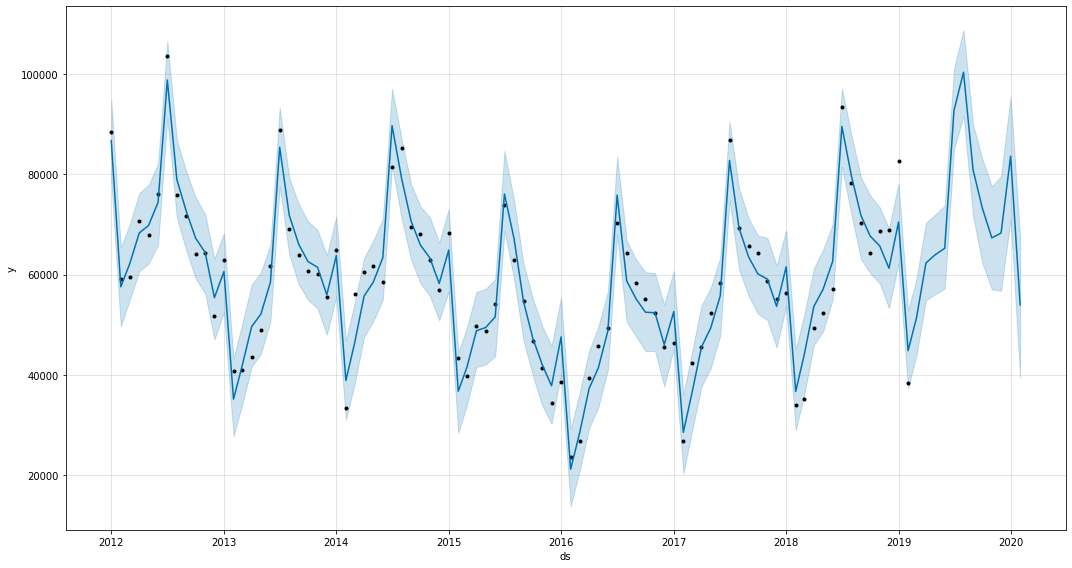

In [ ]:
# Plotting the generated forecast
fig1 = model.plot(forecast, uncertainty=True, figsize=(15,8))

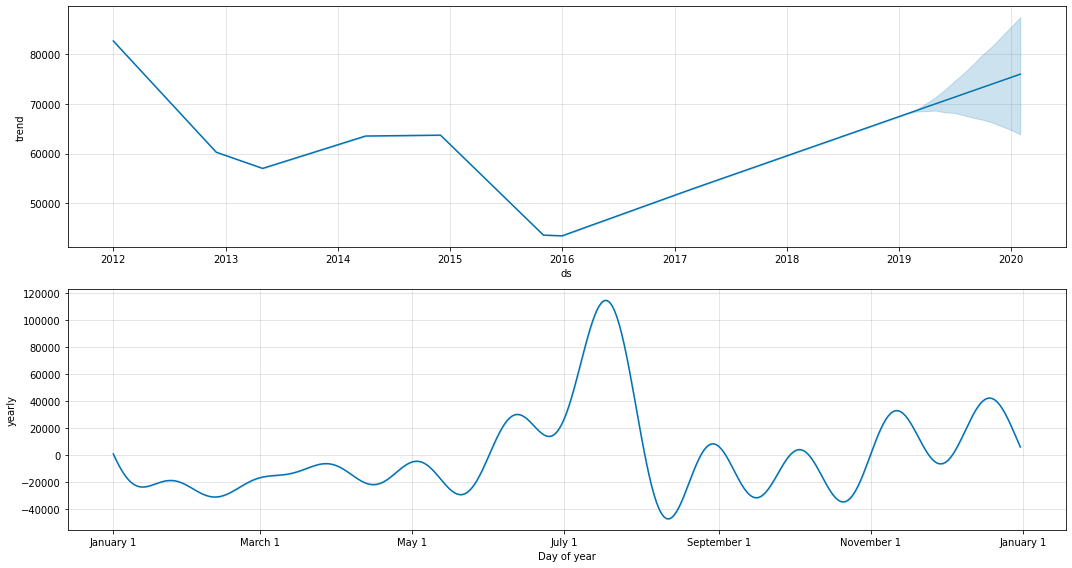

In [ ]:
# Plotting the forecast components.
fig2 = model.plot_components(forecast, figsize=(15,8))

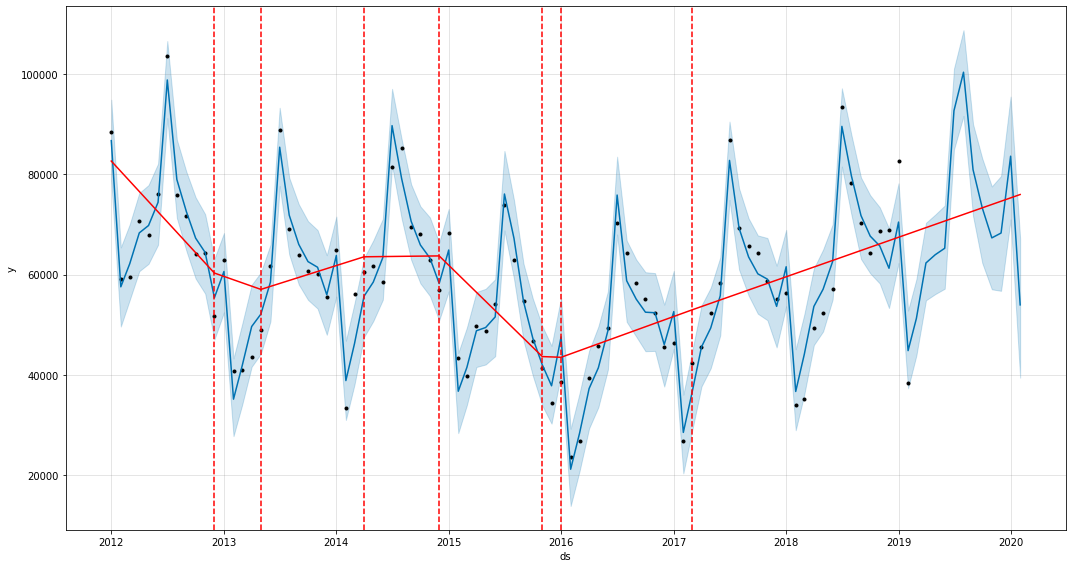

In [ ]:
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(forecast, figsize=(15,8))
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [ ]:
# Listing all the change points in the model
deltas = model.params['delta'].mean(0)
cp = pd.DataFrame(model.changepoints)
cp['deltas'] = deltas
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Bar(x=cp['ds'], y=cp['deltas'], name='CPs',))


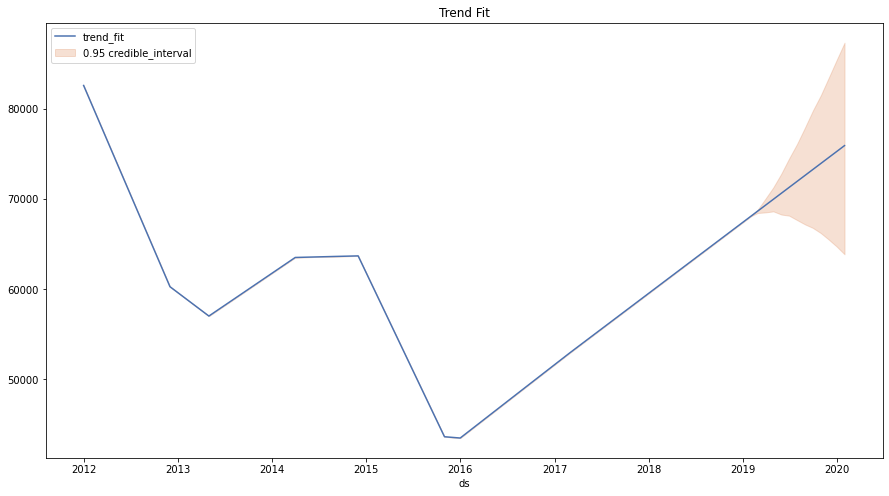

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

# sns.lineplot(x='ds', y='trend', data=df, label='trend_true', ax=ax)

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['trend_lower'],
    y2=forecast['trend_upper'],
    color=sns_c[1], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='trend', data=forecast, label='trend_fit', ax=ax)
ax.legend(loc='upper left')
ax.set(title='Trend Fit', ylabel='');

## Validación cruzada

In [ ]:
from fbprophet.diagnostics import cross_validation

# Fit the model with two years of data and define a horizon of 365 days forcasting per month

df_cv = cross_validation(
    model=model, 
    initial='1825 days',
    period='30.4 days', 
    horizon = '365 days'
)
display(
df_cv.head(),
df_cv.tail()
)

INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-02-01,31812.174205,25616.866169,38037.512150,26817.99999,2017-01-01 19:12:00
1,2017-03-01,37030.589557,30334.852573,43825.985851,42302.00002,2017-01-01 19:12:00
2,2017-04-01,47116.628217,40115.353426,53874.517650,45565.00001,2017-01-01 19:12:00
3,2017-05-01,50291.755418,43003.717578,57213.285232,52396.00001,2017-01-01 19:12:00
4,2017-06-01,57113.175495,49101.035243,64122.723984,58382.99999,2017-01-01 19:12:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
163,2018-10-01,69875.407168,60279.103953,80059.252121,64194.00001,2018-02-01
164,2018-11-01,66293.407119,55365.338648,77493.468591,68665.99998,2018-02-01
165,2018-12-01,60226.576711,47243.145178,72837.525237,68836.99998,2018-02-01
166,2019-01-01,68753.925299,56026.825716,83606.031757,82661.99985,2018-02-01
167,2019-02-01,46427.666734,33102.626063,62534.260769,38387.00008,2018-02-01


In [ ]:
from fbprophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p.head(5)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,58 days 09:36:00,2.868367e+07,5355.713332,4089.096734,0.098878,0.042345,0.87500
1,58 days 14:24:00,2.545126e+07,5044.924109,3923.090802,0.090383,0.042345,0.90625
2,58 days 19:12:00,2.116909e+07,4600.988213,3512.199529,0.079185,0.042345,0.93750
3,59 days 00:00:00,2.196869e+07,4687.076867,3560.644279,0.081926,0.039796,0.93750
4,59 days 04:48:00,2.212131e+07,4703.329763,3619.770684,0.082643,0.039796,0.93750


In [ ]:
df_p.mean()

horizon     215 days 04:55:04.918032788
mse                         4.22183e+07
rmse                            6441.34
mae                             5301.79
mape                           0.107084
mdape                         0.0746667
coverage                       0.839652
dtype: object

In [ ]:
df_cv.assign(abs_error = lambda x: (x['y'] - x['yhat']).abs()) \
    .assign(horizon = lambda x: x['ds'] - x['cutoff']) \
    .assign(horizon = lambda x: x['horizon']) \
    .groupby('horizon', as_index=False) \
    .agg({'abs_error': np.mean}) \
    .rename(columns={'abs_error': 'mae'})

,horizon,mae
0,27 days 19:12:00,6361.120897
1,28 days 00:00:00,6758.549516
2,28 days 04:48:00,4052.035690
3,28 days 09:36:00,1998.654552
4,28 days 14:24:00,817.624439
5,28 days 19:12:00,2684.082633
6,29 days 00:00:00,2178.653439
7,29 days 04:48:00,1089.473700
8,29 days 09:36:00,533.516735
9,29 days 14:24:00,2398.723968


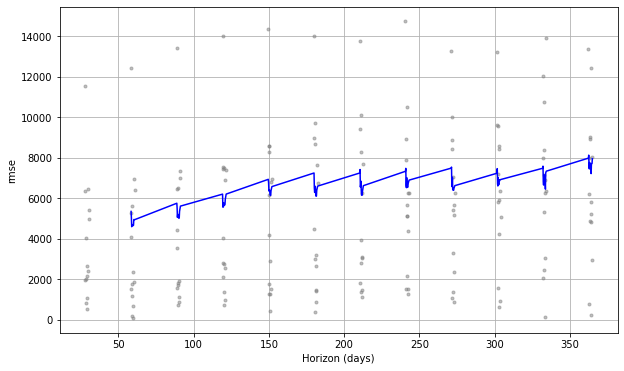

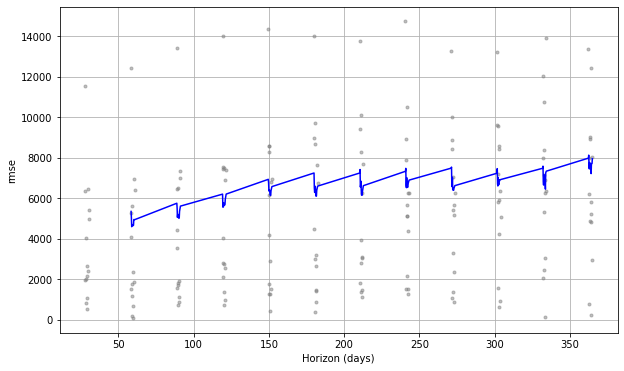

In [ ]:
from fbprophet.plot import plot_cross_validation_metric

plot_cross_validation_metric(df_cv, metric='rmse')


In [ ]:
cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
cutoff = df_cv['cutoff'].unique()[-1]
cutoff

numpy.datetime64('2018-02-01T00:00:00.000000000')

In [ ]:
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

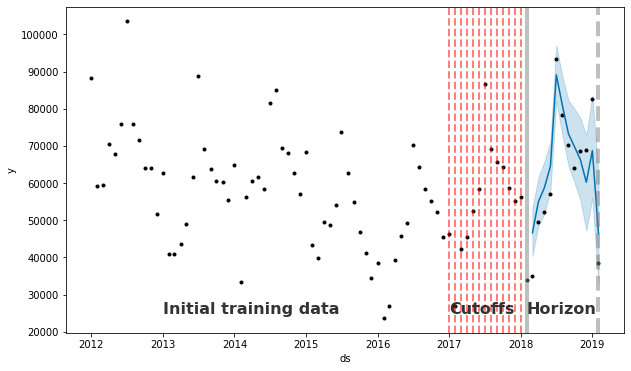

In [ ]:

fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)

ax.plot(model.history['ds'].values, model.history['y'], 'k.')

ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')

ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)

ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')

# Making all the vlines for cutoffs
for item in cutoffs[:-1]:
  ax.axvline(x=pd.to_datetime(item), c='red', lw=2, alpha=0.5, ls='--')

# Adding text to describe the data set splits
ax.text(x=pd.to_datetime('2013-01-01'),y=25000, s='Initial training data', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.text(x=pd.to_datetime('2017-01-01'),y=25000, s='Cutoffs', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.text(x=pd.to_datetime(cutoff) + pd.Timedelta('0 days'),y=25000, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
           alpha=0.5, ls='--')

# Multiples regresores prophet

In [ ]:
reg_cols

['regr0',
 'regr1',
 'regr2',
 'regr3',
 'regr4',
 'regr5',
 'regr6',
 'regr7',
 'regr8',
 'regr9',
 'regr10',
 'regr11',
 'regr12',
 'regr13',
 'regr14',
 'regr15',
 'regr16',
 'regr17',
 'regr18',
 'regr19',
 'regr20',
 'regr21',
 'regr22',
 'regr23',
 'regr24']

In [ ]:
def fit_regressor(df_train, df_test, reg_cols):
    # Split the data and select `ds` and `y` columns.
    df_train = df[mask][['ds', 'y'] + reg_cols]
    df_test = df[~ mask][['ds', 'y'] + reg_cols]
    print(df_train.shape)
    print(df_test.shape)
    df_test.tail()


    # Fitting a Prophet model
    model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False, 
            interval_width=0.95)

    for col in reg_cols:
        model.add_regressor(col)

    model.fit(df_train)

    # Extend dates and features. 
    future = model.make_future_dataframe(periods=df_test.shape[0], freq='M')

    future = future.merge(df[reg_cols ], left_index=True, right_index=True)

    # Generate predictions. 
    forecast = model.predict(df=future)

    mask2 = forecast['ds'] <= threshold_date

    forecast_train = forecast[mask2]
    forecast_test = forecast[~ mask2]
    print('RMSE train: {}'.format(sqrt(mean_squared_error(y_true=df_train['y'], y_pred=forecast_train['yhat']))))
    print('RMSE test: {}'.format(sqrt(mean_squared_error(y_true=df_test['y'], y_pred=forecast_test['yhat']))))

    
    return sqrt(mean_squared_error(y_true=df_train['y'], y_pred=forecast_train['yhat']))

In [ ]:
# Split the data and select `ds` and `y` columns.
df_train = df[mask][['ds', 'y'] + reg_cols]
df_test = df[~ mask][['ds', 'y'] + reg_cols]
print(df_train.shape)
print(df_test.shape)
df_test.tail()

(86, 27)
(12, 27)


,ds,y,regr0,regr1,regr2,regr3,regr4,regr5,regr6,regr7,regr8,regr9,regr10,regr11,regr12,regr13,regr14,regr15,regr16,regr17,regr18,regr19,regr20,regr21,regr22,regr23,regr24
93,2019-10-01,67129.0,4.082545,40.133333,25.066667,10.633333,6.933333,4.466667,11.533333,1.033333,547.615867,0.10,58.514548,135.3,22.0,13.0,1,0.043919,0.060662,0.113321,0.305466,0.089875,0.209449,0.016320,0.027724,10,14.332859
94,2019-11-01,64563.0,4.155795,39.666667,24.433333,10.466667,6.766667,4.333333,11.266667,1.066667,541.011642,0.51,59.727230,131.3,27.8,17.6,1,0.042832,0.076537,0.121450,0.334648,0.092752,0.200144,0.016280,0.028345,11,14.372036
95,2019-12-01,68464.0,4.104486,39.200000,23.800000,10.300000,6.600000,4.200000,11.000000,1.100000,550.860731,1.15,59.878494,129.0,29.5,18.0,1,0.043082,0.065981,0.121543,0.342626,0.094452,0.185835,0.017419,0.029164,12,14.588550
96,2020-01-01,75454.0,4.151162,40.800000,24.900000,10.600000,6.900000,4.266667,11.400000,1.033333,549.645309,0.21,59.989139,125.3,30.0,20.2,1,0.044465,0.065381,0.115402,0.323791,0.123023,0.188631,0.015793,0.032666,1,14.451168
97,2020-02-01,44684.0,4.347016,42.400000,26.000000,10.900000,7.200000,4.333333,11.800000,0.966667,529.635374,0.25,61.342562,119.8,29.6,19.3,1,0.041284,0.072024,0.111596,0.281459,0.118135,0.201208,0.011223,0.024019,2,14.111419


In [ ]:
import itertools

# lst = ['regr0', 'regr1', 'regr2', 'regr3', 'regr4', 'regr5', 'regr6']
lst = reg_cols.copy()
combs = []
min_acc = 1000000
best_cols = []
# for i in range(1, len(lst)+1):
for i in range(1, 2):
#     combs.append(i)
    els = [list(x) for x in itertools.combinations(lst, i)]
    for i in els:
        print(i)

        error = fit_regressor(df_train,df_test,i)
        if error < min_acc:
            min_acc = error
            best_cols = i
            print('*** New Min error: ', error)
            print('*** Best features: ', i)
            print('*** Best features: ', best_cols)
            print('*** \n')
# combs

['regr0']
(86, 3)
(12, 3)
RMSE train: 5884.88820427494
RMSE test: 12504.019030301777
*** New Min error:  5884.88820427494
*** Best features:  ['regr0']
*** Best features:  ['regr0']
*** 

['regr1']
(86, 3)
(12, 3)
RMSE train: 6055.386990950039
RMSE test: 10463.242690171088
['regr2']
(86, 3)
(12, 3)
RMSE train: 5995.569894586399
RMSE test: 10590.557863909453
['regr3']
(86, 3)
(12, 3)
RMSE train: 5898.813041913541
RMSE test: 10349.633955471054
['regr4']
(86, 3)
(12, 3)
RMSE train: 5955.680732906101
RMSE test: 10164.194071333866
['regr5']
(86, 3)
(12, 3)
RMSE train: 6118.845209604309
RMSE test: 10148.641848713109
['regr6']
(86, 3)
(12, 3)
RMSE train: 5951.671166514441
RMSE test: 10455.422990529809
['regr7']
(86, 3)
(12, 3)
RMSE train: 5940.897294216174
RMSE test: 12891.460294099192
['regr8']
(86, 3)
(12, 3)
RMSE train: 5900.171130107865
RMSE test: 11893.11172020725
['regr9']
(86, 3)
(12, 3)
RMSE train: 6339.3587188843785
RMSE test: 10427.938197593812
['regr10']
(86, 3)
(12, 3)
RMSE train:

In [ ]:
best_cols

['regr21']

In [ ]:
# Fitting a Prophet model
model_2 = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False, 
        interval_width=0.95,
        changepoint_prior_scale = 0.5,
)

for col in best_cols:
    model_2.add_regressor(col)
    
model_2.fit(df_train)

In [ ]:
# Extend dates and features. 
future = model_2.make_future_dataframe(periods=df_test.shape[0], freq='M')

future = future.merge(df[reg_cols ], left_index=True, right_index=True)

# Generate predictions. 
forecast = model_2.predict(df=future)

In [ ]:
mask2 = forecast['ds'] <= threshold_date

forecast_train = forecast[mask2]
forecast_test = forecast[~ mask2]

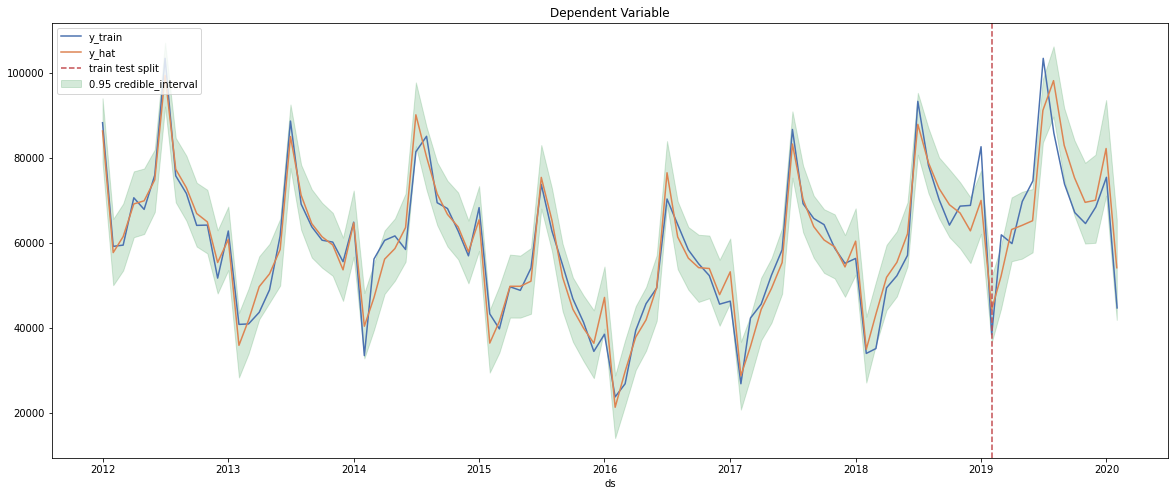

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df, ax=ax)
# sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

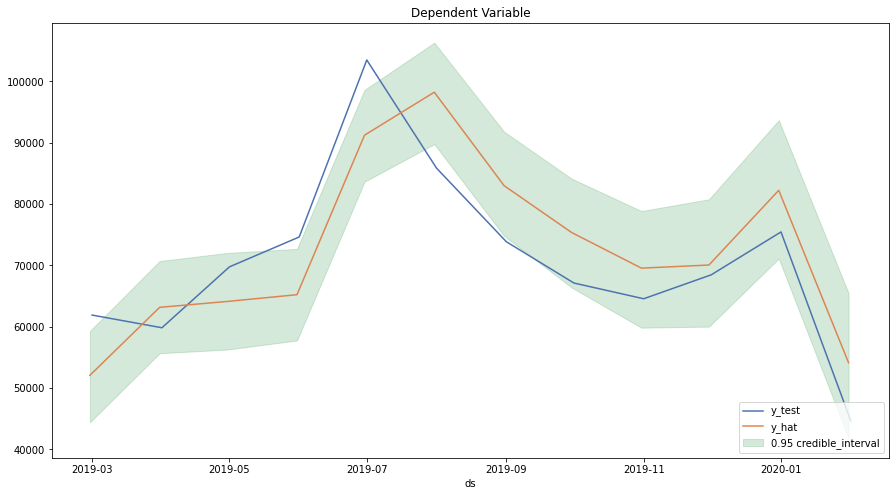

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

ax.fill_between(
    x=forecast_test['ds'],
    y1=forecast_test['yhat_lower'],
    y2=forecast_test['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.legend(loc='lower right')
ax.set(title='Dependent Variable', ylabel='');

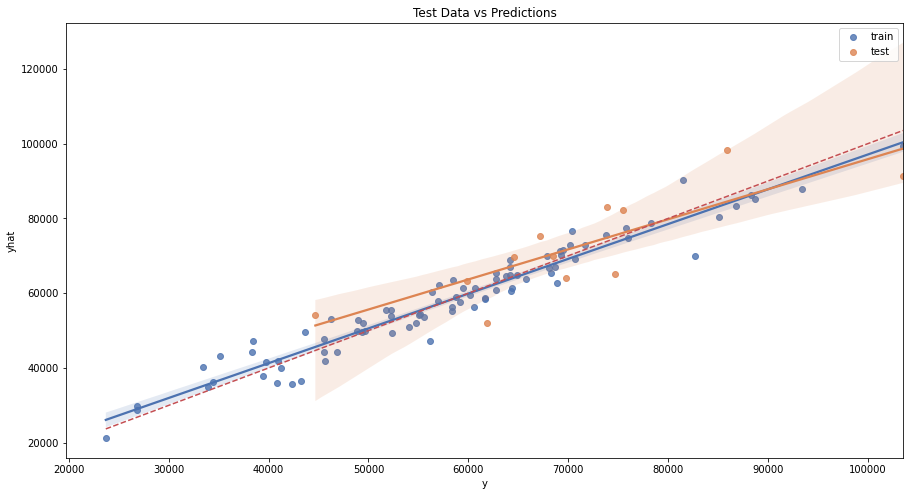

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

# Generate diagonal line to plot. 
d_x = np.linspace(start=df_train['y'].min() - 1, stop=df_train['y'].max() + 1, num=100)

sns.regplot(x=df_train['y'], y=forecast_train['yhat'], color=sns_c[0], label='train', ax=ax)
sns.regplot(x=df_test['y'], y=forecast_test['yhat'], color=sns_c[1], label='test', ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, color=sns_c[3], ax=ax)
ax.lines[2].set_linestyle('--')
ax.set(title='Test Data vs Predictions');

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

print('r2 train: {}'.format(r2_score(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('r2 test: {}'.format(r2_score(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('---'*10)
print('mae train: {}'.format(mean_absolute_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mae test: {}'.format(mean_absolute_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('mape train: {}'.format(mean_absolute_percentage_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mape test: {}'.format(mean_absolute_percentage_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))


print('RMSE train: {}'.format(sqrt(mean_squared_error(y_true=df_train['y'], y_pred=forecast_train['yhat']))))
print('RMSE test: {}'.format(sqrt(mean_squared_error(y_true=df_test['y'], y_pred=forecast_test['yhat']))))

r2 train: 0.9379543286441125
r2 test: 0.62910490436564
------------------------------
mae train: 3069.6805914751835
mae test: 7754.113468978241
mape train: 5.783333509845221
mape test: 11.105407390696776
RMSE train: 3880.6294498429916
RMSE test: 8395.834045261869


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.



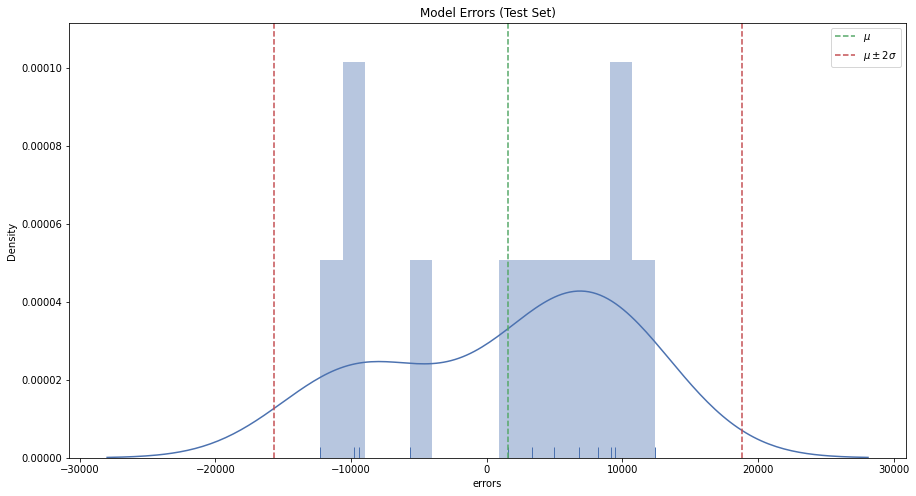

In [ ]:
forecast_test.loc[:, 'errors'] = forecast_test.loc[:, 'yhat'] - df_test.loc[:, 'y']

errors_mean = forecast_test['errors'].mean()
errors_std = forecast_test['errors'].std()

fig, ax = plt.subplots(figsize=(15,8))

sns.distplot(a=forecast_test['errors'], ax=ax, bins=15, rug=True)
ax.axvline(x=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$')
ax.axvline(x=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axvline(x=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

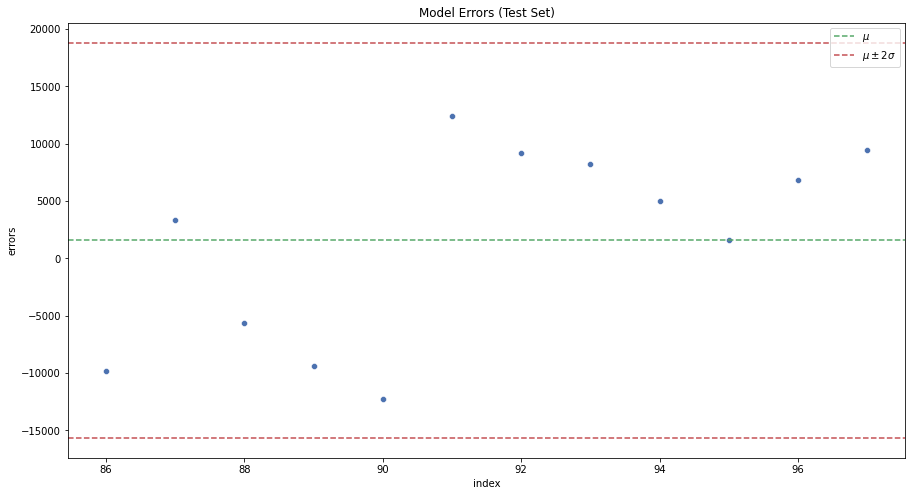

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

sns.scatterplot(x='index', y='errors', data=forecast_test.reset_index(), ax=ax)
ax.axhline(y=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$ ')
ax.axhline(y=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axhline(y=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



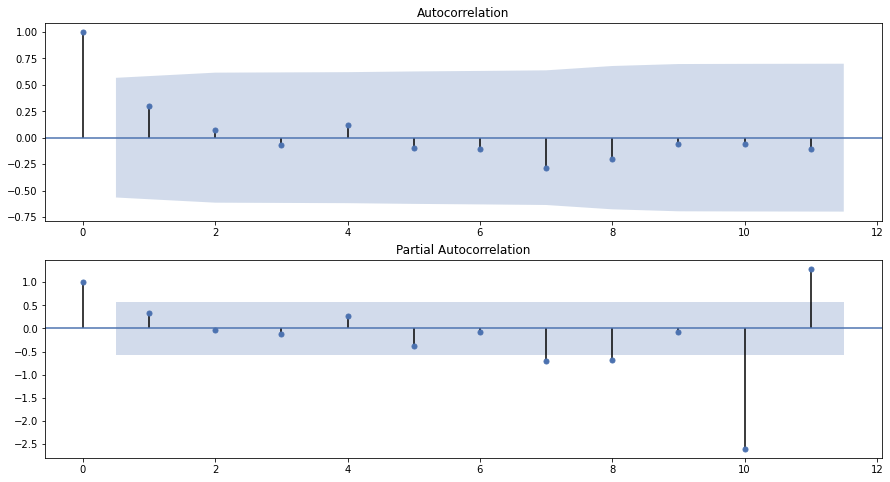

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(15,8))
plot_acf(x=forecast_test['errors'], ax=ax[0])
plot_pacf(x=forecast_test['errors'], ax=ax[1]);

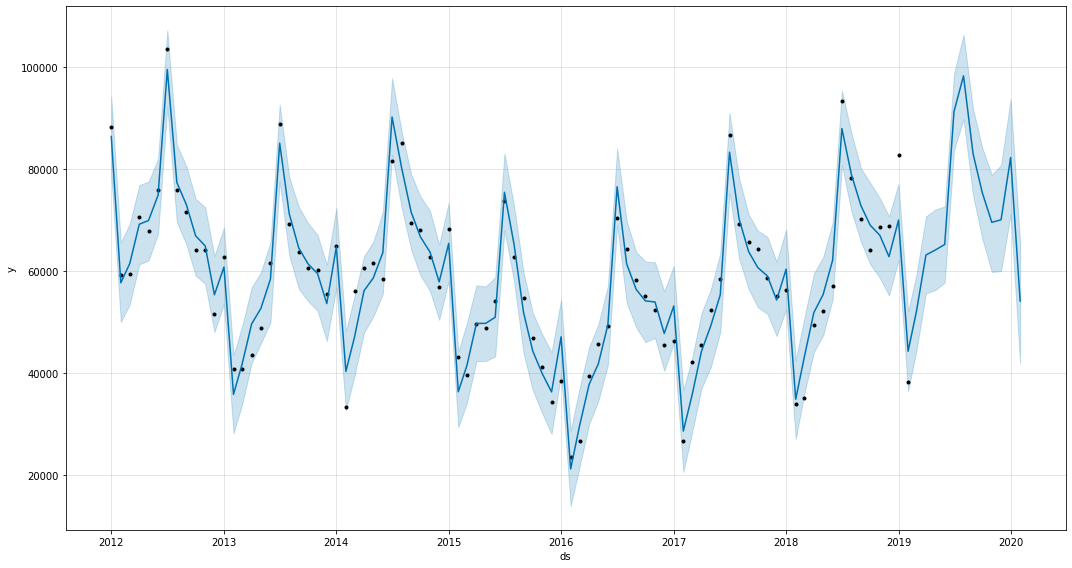

In [ ]:
# Plotting the generated forecast
fig1 = model_2.plot(forecast, uncertainty=True, figsize=(15,8))

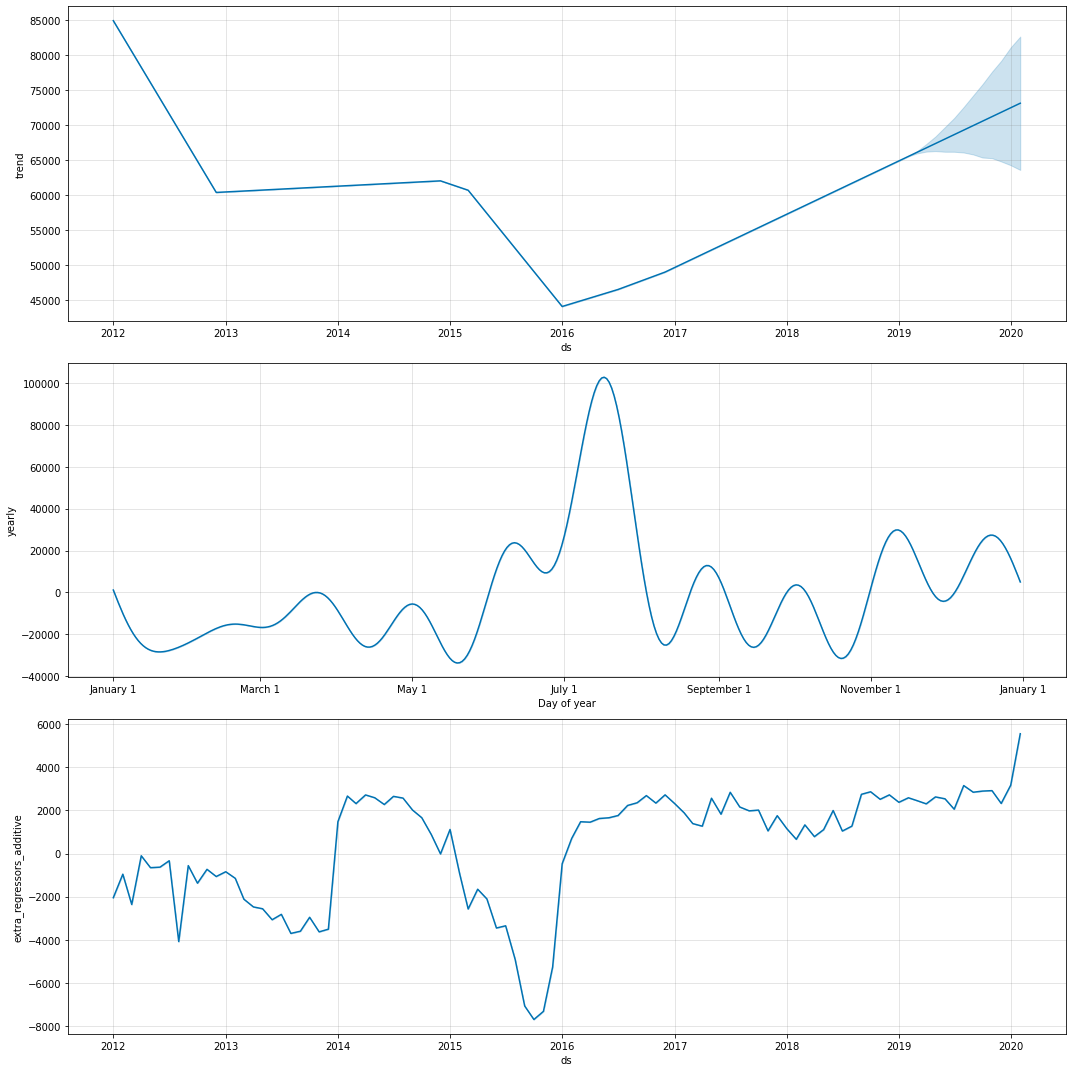

In [ ]:
# Plotting the forecast components.
fig2 = model_2.plot_components(forecast, figsize=(15,15))

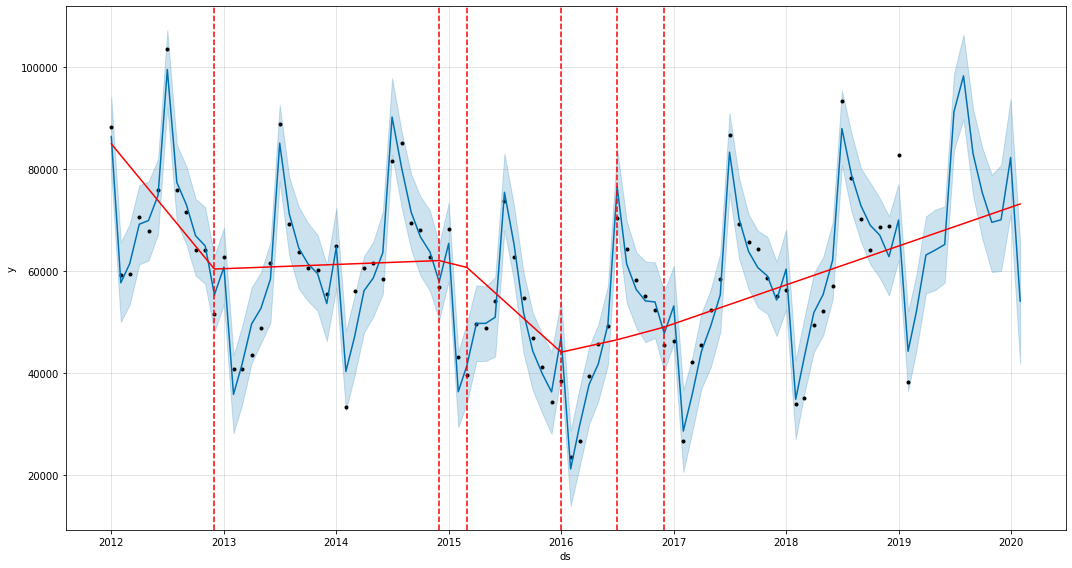

In [ ]:
from fbprophet.plot import add_changepoints_to_plot

fig = model_2.plot(forecast, figsize=(15,8))
a = add_changepoints_to_plot(fig.gca(), model_2, forecast)

In [ ]:
# Listing all the change points in the model
deltas = model_2.params['delta'].mean(0)
cp = pd.DataFrame(model_2.changepoints)
cp['deltas'] = deltas
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Bar(x=cp['ds'], y=cp['deltas'], name='CPs',))


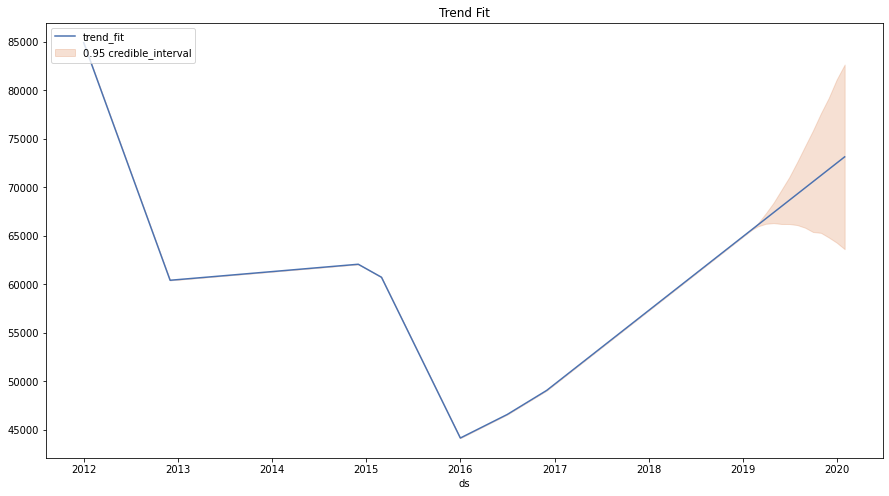

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

# sns.lineplot(x='ds', y='trend', data=df, label='trend_true', ax=ax)

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['trend_lower'],
    y2=forecast['trend_upper'],
    color=sns_c[1], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='trend', data=forecast, label='trend_fit', ax=ax)
ax.legend(loc='upper left')
ax.set(title='Trend Fit', ylabel='');

## Validación cruzada

In [ ]:
from fbprophet.diagnostics import cross_validation

# Fit the model with two years of data and define a horizon of 365 days forcasting per month

df_cv = cross_validation(
    model=model_2, 
    initial='1825 days',
    period='30.4 days', 
    horizon = '365 days'
)
display(
df_cv.head(),
df_cv.tail()
)

INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-02-01,27298.289550,21424.048094,33338.437679,26817.99999,2017-01-01 19:12:00
1,2017-03-01,30989.101031,24172.292697,37669.587929,42302.00002,2017-01-01 19:12:00
2,2017-04-01,39520.770654,32740.616295,46101.614911,45565.00001,2017-01-01 19:12:00
3,2017-05-01,43763.511007,36692.674847,50509.157108,52396.00001,2017-01-01 19:12:00
4,2017-06-01,49761.095283,42793.542460,56847.309901,58382.99999,2017-01-01 19:12:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
163,2018-10-01,71398.115942,62042.799243,79620.017921,64194.00001,2018-02-01
164,2018-11-01,67613.192326,58183.667404,76136.596872,68665.99998,2018-02-01
165,2018-12-01,62006.350991,51846.808481,71803.713615,68836.99998,2018-02-01
166,2019-01-01,67773.767509,54915.614015,78515.915080,82661.99985,2018-02-01
167,2019-02-01,45766.961482,33655.174514,57220.224569,38387.00008,2018-02-01


In [ ]:
from fbprophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p.head(5)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,58 days 09:36:00,3.047212e+07,5520.155852,4253.530927,0.095957,0.051533,0.81250
1,58 days 14:24:00,2.812399e+07,5303.205961,4119.094007,0.087920,0.051533,0.84375
2,58 days 19:12:00,2.616363e+07,5115.039314,4021.088027,0.083956,0.051533,0.87500
3,59 days 00:00:00,2.601453e+07,5100.443855,4019.994819,0.085447,0.058643,0.87500
4,59 days 04:48:00,2.583267e+07,5082.585119,3979.091058,0.084429,0.058643,0.87500


In [ ]:
df_p.mean()

horizon     215 days 04:55:04.918032788
mse                         3.72123e+07
rmse                            6072.81
mae                             5143.11
mape                          0.0962878
mdape                         0.0830419
coverage                       0.834529
dtype: object

In [ ]:
df_cv.assign(abs_error = lambda x: (x['y'] - x['yhat']).abs()) \
    .assign(horizon = lambda x: x['ds'] - x['cutoff']) \
    .assign(horizon = lambda x: x['horizon']) \
    .groupby('horizon', as_index=False) \
    .agg({'abs_error': np.mean}) \
    .rename(columns={'abs_error': 'mae'})

,horizon,mae
0,27 days 19:12:00,10861.552837
1,28 days 00:00:00,7181.405363
2,28 days 04:48:00,4476.738715
3,28 days 09:36:00,2344.364760
4,28 days 14:24:00,2550.204539
5,28 days 19:12:00,2469.514698
6,29 days 00:00:00,2076.628690
7,29 days 04:48:00,1084.242078
8,29 days 09:36:00,971.589825
9,29 days 14:24:00,1880.294550


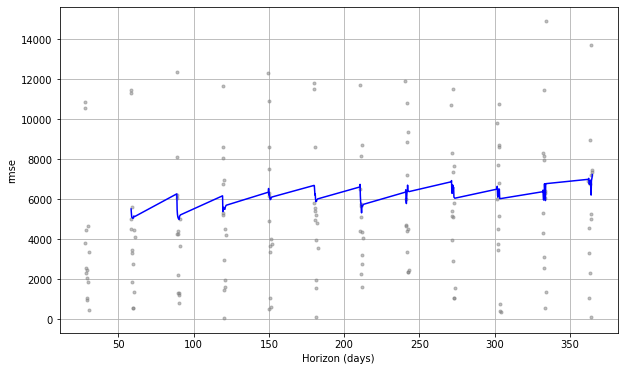

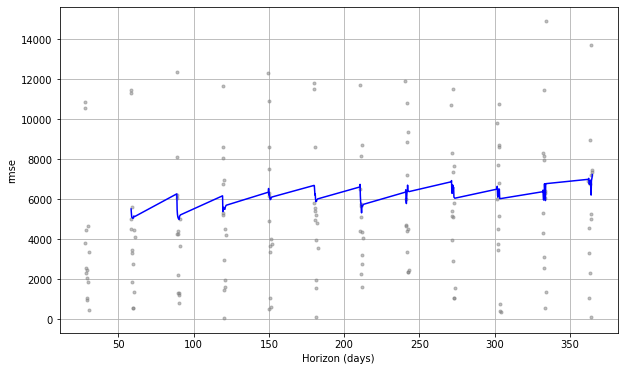

In [ ]:
from fbprophet.plot import plot_cross_validation_metric

plot_cross_validation_metric(df_cv, metric='rmse')


In [ ]:
cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
cutoff = df_cv['cutoff'].unique()[-1]
cutoff

numpy.datetime64('2018-02-01T00:00:00.000000000')

In [ ]:
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

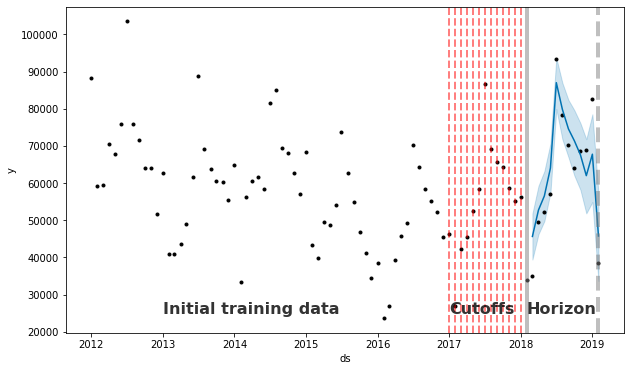

In [ ]:

fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)

ax.plot(model_2.history['ds'].values, model_2.history['y'], 'k.')

ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')

ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)

ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')

# Making all the vlines for cutoffs
for item in cutoffs[:-1]:
  ax.axvline(x=pd.to_datetime(item), c='red', lw=2, alpha=0.5, ls='--')

# Adding text to describe the data set splits
ax.text(x=pd.to_datetime('2013-01-01'),y=25000, s='Initial training data', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.text(x=pd.to_datetime('2017-01-01'),y=25000, s='Cutoffs', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.text(x=pd.to_datetime(cutoff) + pd.Timedelta('0 days'),y=25000, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
           alpha=0.5, ls='--')

# Multiples regresores prophet

2012	mie	22 de feb	Ash Wednesday	Christian
2013	mie	13 de feb	Ash Wednesday	Christian
2014	mie	5 de mar	Ash Wednesday	Christian

In [ ]:
from datetime import timedelta
import datetime

holidays = pd.DataFrame(columns=['holiday','ds','lower_window','upper_window'])

dates_carn = ['2012-02-22','2013-02-13','2014-03-05','2015-02-18','2016-02-10',
                  '2017-03-01','2018-02-14','2019-03-06','2020-02-26']

for date in dates_carn:
  date_1 = datetime.datetime.strptime(date, '%Y-%m-%d')
  end_date = date_1 + datetime.timedelta(days=-5)
  holiday_year = pd.DataFrame(columns=['holiday','ds','lower_window','upper_window'])

  holiday_year['ds'] =pd.date_range(start=end_date, periods=5, freq='D')
  holiday_year['holiday'].fillna('Carnaval', inplace=True)
  holiday_year['lower_window'].fillna(0, inplace=True)
  holiday_year['upper_window'].fillna(0, inplace=True)
  holidays = pd.concat([holidays,holiday_year], ignore_index=True)
holidays.tail()

,holiday,ds,lower_window,upper_window
40,Carnaval,2020-02-21,0,0
41,Carnaval,2020-02-22,0,0
42,Carnaval,2020-02-23,0,0
43,Carnaval,2020-02-24,0,0
44,Carnaval,2020-02-25,0,0


In [ ]:
# http://www.turismo.gob.ar/noticias/2016/08/19/argentina-y-brasil-firmaron-un-acuerdo-de-cooperacion

In [ ]:
# Split the data and select `ds` and `y` columns.
df_train = df[mask][['ds', 'y'] + reg_cols]
df_test = df[~ mask][['ds', 'y'] + reg_cols]
print(df_train.shape)
print(df_test.shape)
df_test.tail()

(86, 27)
(12, 27)


,ds,y,regr0,regr1,regr2,regr3,regr4,regr5,regr6,regr7,regr8,regr9,regr10,regr11,regr12,regr13,regr14,regr15,regr16,regr17,regr18,regr19,regr20,regr21,regr22,regr23,regr24
93,2019-10-01,67129.0,4.082545,40.133333,25.066667,10.633333,6.933333,4.466667,11.533333,1.033333,547.615867,0.10,58.514548,135.3,22.0,13.0,1,0.043919,0.060662,0.113321,0.305466,0.089875,0.209449,0.016320,0.027724,10,14.332859
94,2019-11-01,64563.0,4.155795,39.666667,24.433333,10.466667,6.766667,4.333333,11.266667,1.066667,541.011642,0.51,59.727230,131.3,27.8,17.6,1,0.042832,0.076537,0.121450,0.334648,0.092752,0.200144,0.016280,0.028345,11,14.372036
95,2019-12-01,68464.0,4.104486,39.200000,23.800000,10.300000,6.600000,4.200000,11.000000,1.100000,550.860731,1.15,59.878494,129.0,29.5,18.0,1,0.043082,0.065981,0.121543,0.342626,0.094452,0.185835,0.017419,0.029164,12,14.588550
96,2020-01-01,75454.0,4.151162,40.800000,24.900000,10.600000,6.900000,4.266667,11.400000,1.033333,549.645309,0.21,59.989139,125.3,30.0,20.2,1,0.044465,0.065381,0.115402,0.323791,0.123023,0.188631,0.015793,0.032666,1,14.451168
97,2020-02-01,44684.0,4.347016,42.400000,26.000000,10.900000,7.200000,4.333333,11.800000,0.966667,529.635374,0.25,61.342562,119.8,29.6,19.3,1,0.041284,0.072024,0.111596,0.281459,0.118135,0.201208,0.011223,0.024019,2,14.111419


In [ ]:
# Fitting a Prophet model
model_3 = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False, 
        interval_width=0.95,
        changepoint_prior_scale = 0.5,
        holidays = holidays)

for col in best_cols:
    model_3.add_regressor(col)
    
model_3.fit(df_train)

In [ ]:
# Extend dates and features. 
future = model_3.make_future_dataframe(periods=df_test.shape[0], freq='M')

future = future.merge(df[reg_cols ], left_index=True, right_index=True)

# Generate predictions. 
forecast = model_3.predict(df=future)

In [ ]:
mask2 = forecast['ds'] <= threshold_date

forecast_train = forecast[mask2]
forecast_test = forecast[~ mask2]

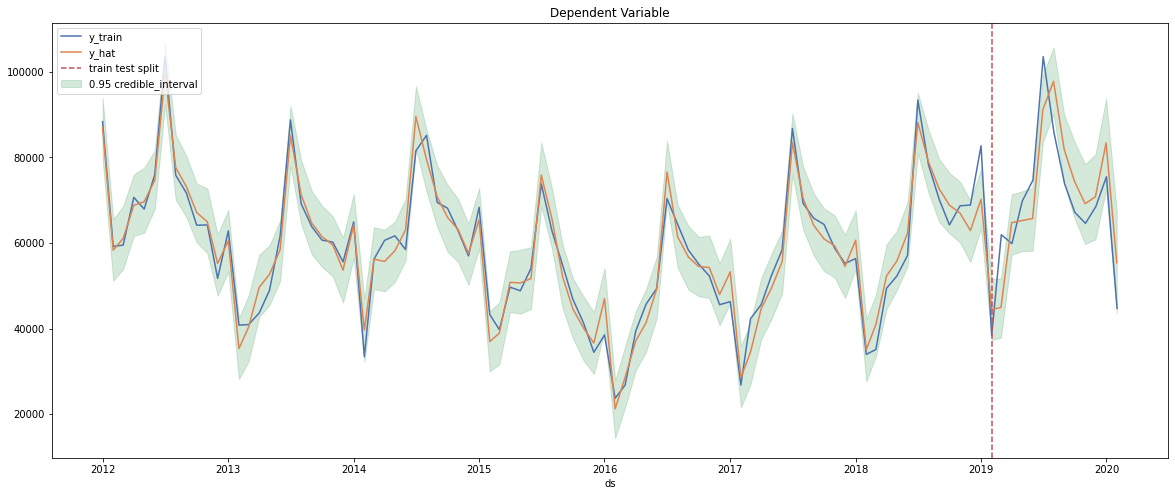

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df, ax=ax)
# sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

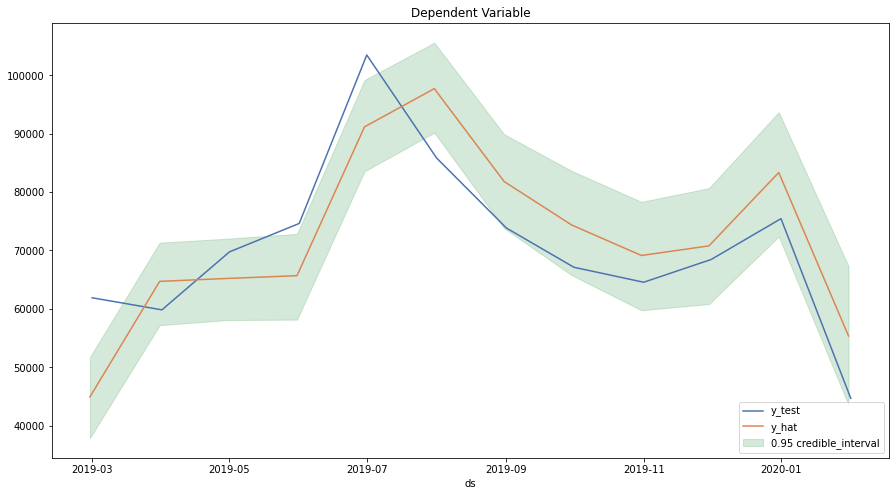

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

ax.fill_between(
    x=forecast_test['ds'],
    y1=forecast_test['yhat_lower'],
    y2=forecast_test['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.legend(loc='lower right')
ax.set(title='Dependent Variable', ylabel='');

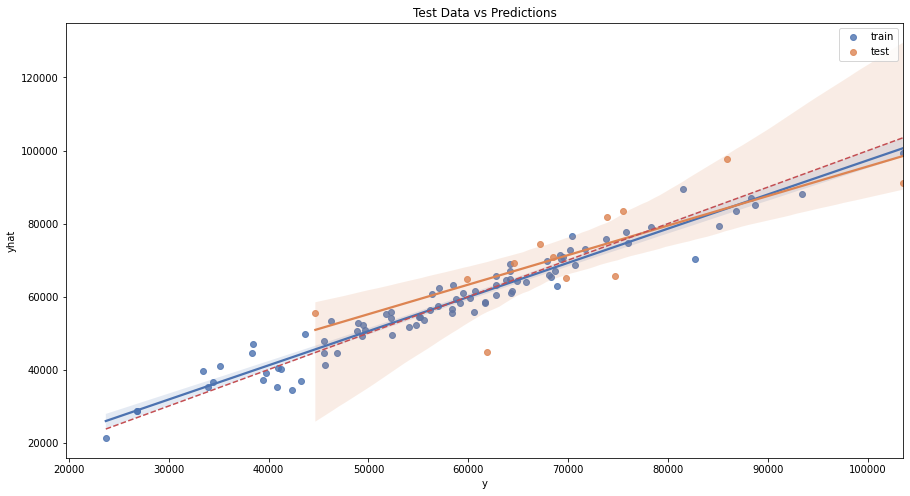

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

# Generate diagonal line to plot. 
d_x = np.linspace(start=df_train['y'].min() - 1, stop=df_train['y'].max() + 1, num=100)

sns.regplot(x=df_train['y'], y=forecast_train['yhat'], color=sns_c[0], label='train', ax=ax)
sns.regplot(x=df_test['y'], y=forecast_test['yhat'], color=sns_c[1], label='test', ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, color=sns_c[3], ax=ax)
ax.lines[2].set_linestyle('--')
ax.set(title='Test Data vs Predictions');

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

print('r2 train: {}'.format(r2_score(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('r2 test: {}'.format(r2_score(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('---'*10)
print('mae train: {}'.format(mean_absolute_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mae test: {}'.format(mean_absolute_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('mape train: {}'.format(mean_absolute_percentage_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mape test: {}'.format(mean_absolute_percentage_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))


print('RMSE train: {}'.format(sqrt(mean_squared_error(y_true=df_train['y'], y_pred=forecast_train['yhat']))))
print('RMSE test: {}'.format(sqrt(mean_squared_error(y_true=df_test['y'], y_pred=forecast_test['yhat']))))

r2 train: 0.9437154900790421
r2 test: 0.5507436242856851
------------------------------
mae train: 2931.549282689805
mae test: 8354.067584035363
mape train: 5.484956156645397
mape test: 12.190283885710862
RMSE train: 3696.0758539951903
RMSE test: 9240.286242548265


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2055: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.



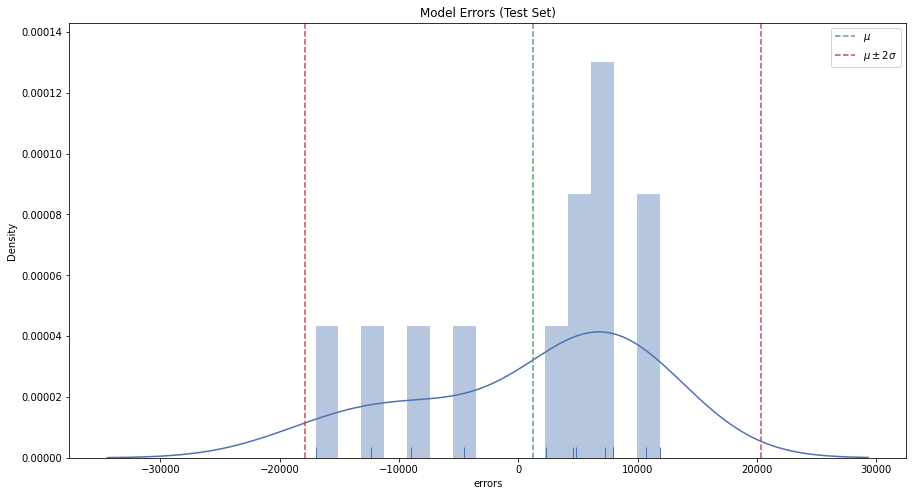

In [ ]:
forecast_test.loc[:, 'errors'] = forecast_test.loc[:, 'yhat'] - df_test.loc[:, 'y']

errors_mean = forecast_test['errors'].mean()
errors_std = forecast_test['errors'].std()

fig, ax = plt.subplots(figsize=(15,8))

sns.distplot(a=forecast_test['errors'], ax=ax, bins=15, rug=True)
ax.axvline(x=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$')
ax.axvline(x=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axvline(x=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

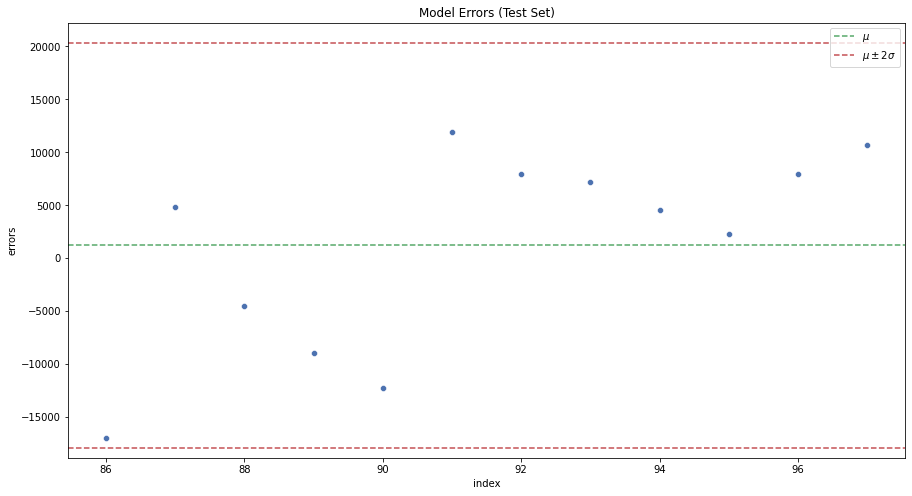

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

sns.scatterplot(x='index', y='errors', data=forecast_test.reset_index(), ax=ax)
ax.axhline(y=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$ ')
ax.axhline(y=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axhline(y=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



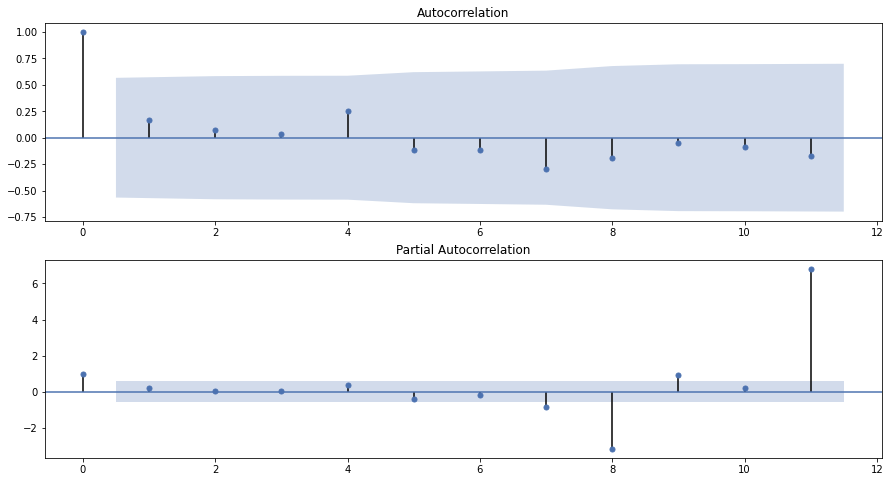

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(15,8))
plot_acf(x=forecast_test['errors'], ax=ax[0])
plot_pacf(x=forecast_test['errors'], ax=ax[1]);

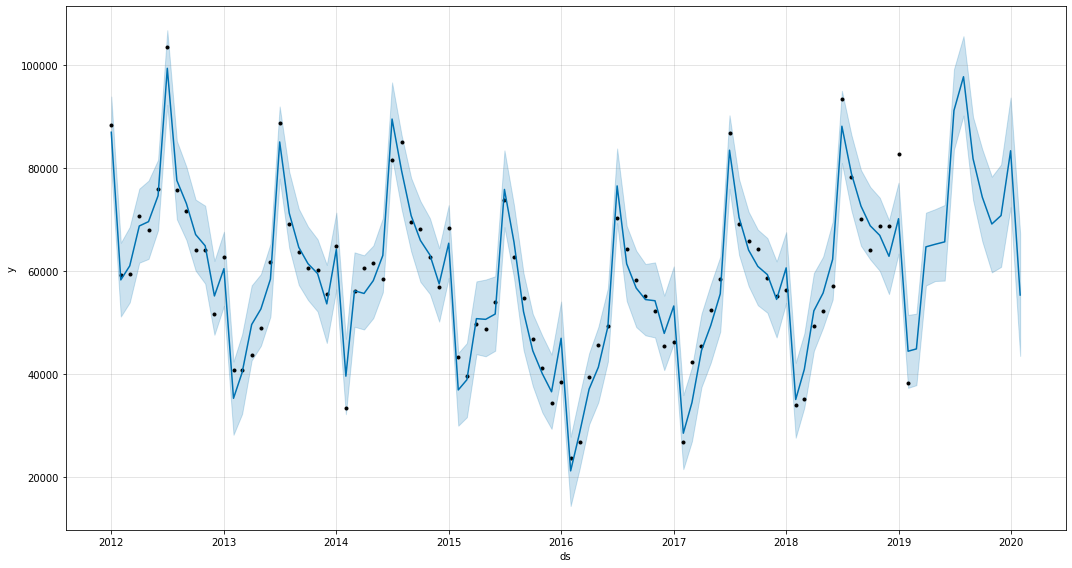

In [ ]:
# Plotting the generated forecast
fig1 = model_3.plot(forecast, uncertainty=True, figsize=(15,8))

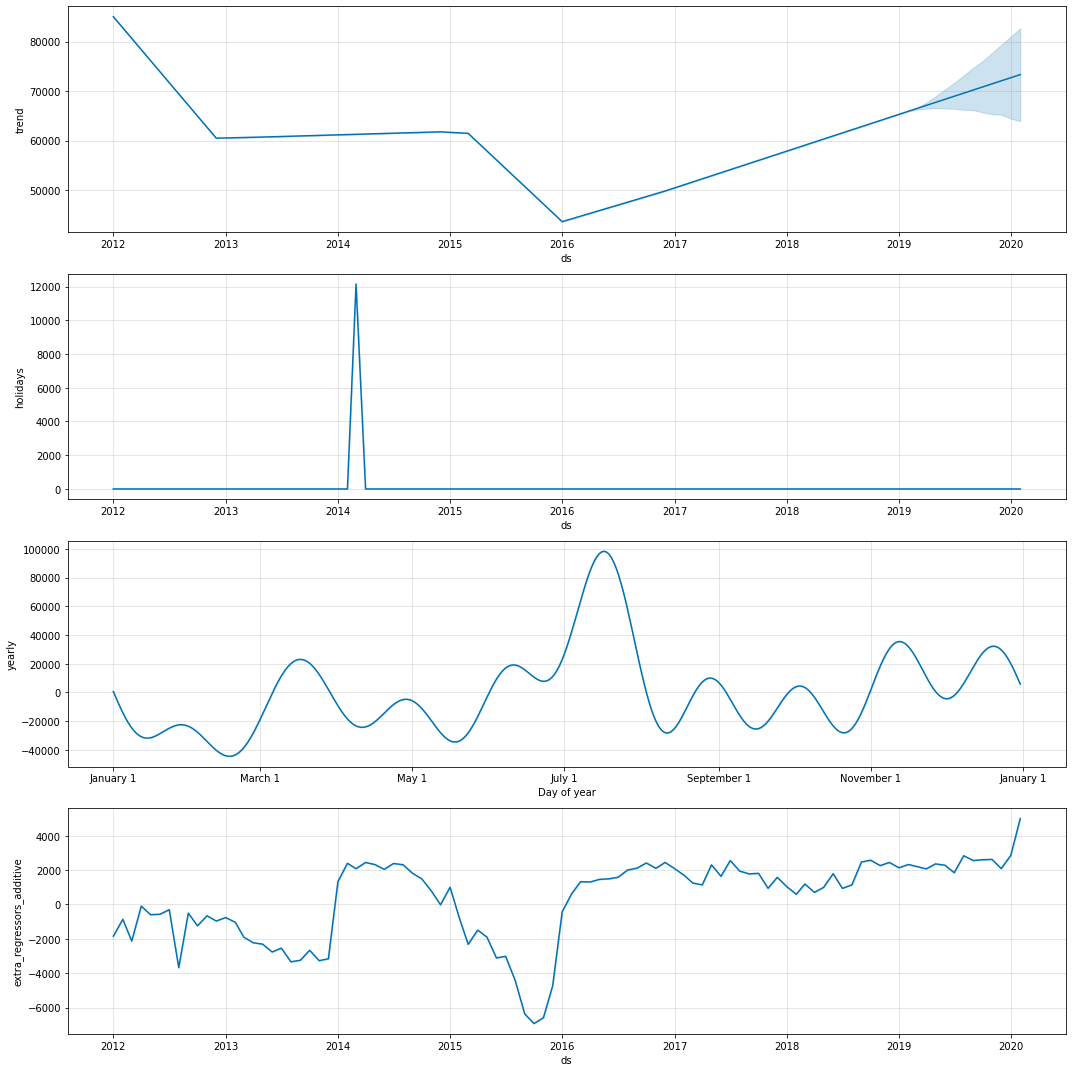

In [ ]:
# Plotting the forecast components.
fig2 = model_3.plot_components(forecast, figsize=(15,15))

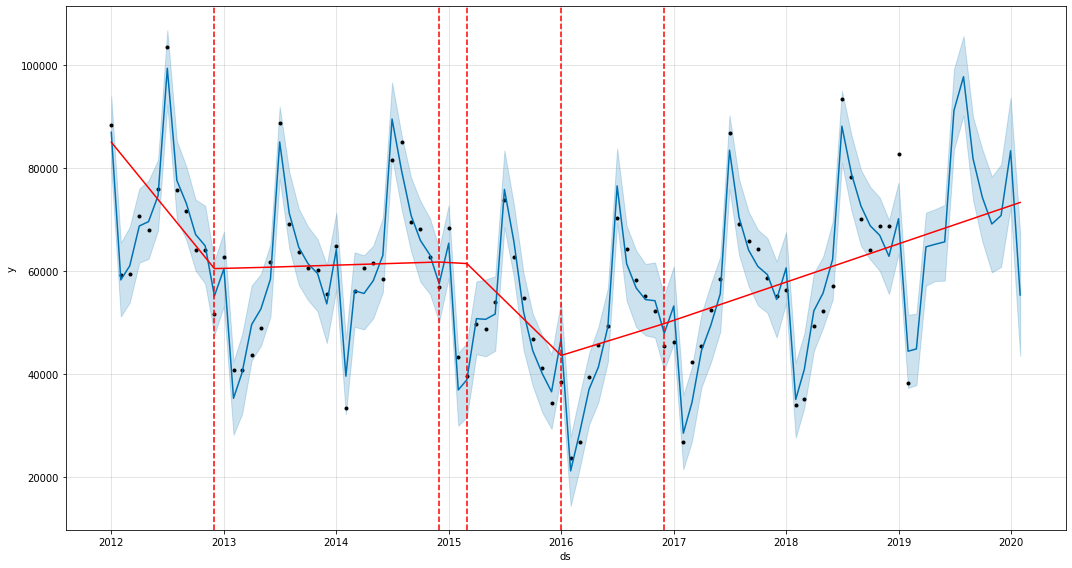

In [ ]:
from fbprophet.plot import add_changepoints_to_plot

fig = model_3.plot(forecast, figsize=(15,8))
a = add_changepoints_to_plot(fig.gca(), model_3, forecast)

In [ ]:
# Listing all the change points in the model
deltas = model_3.params['delta'].mean(0)
cp = pd.DataFrame(model_3.changepoints)
cp['deltas'] = deltas
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Bar(x=cp['ds'], y=cp['deltas'], name='CPs',))


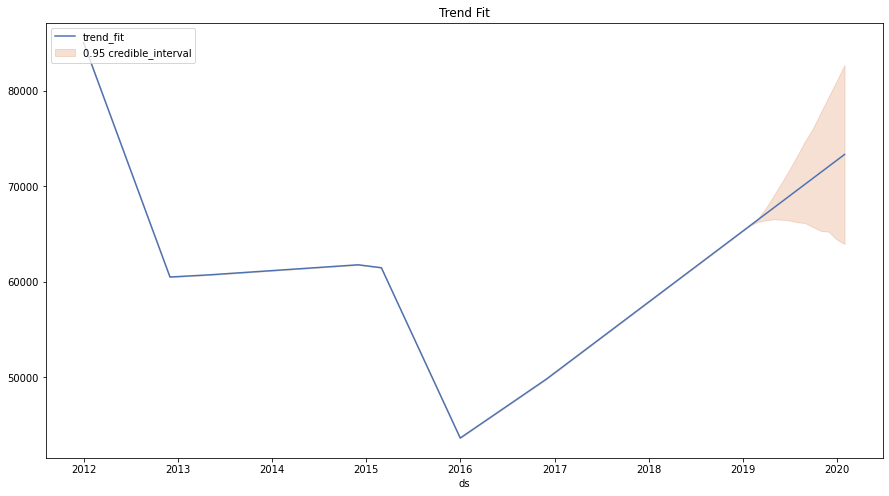

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

# sns.lineplot(x='ds', y='trend', data=df, label='trend_true', ax=ax)

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['trend_lower'],
    y2=forecast['trend_upper'],
    color=sns_c[1], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='trend', data=forecast, label='trend_fit', ax=ax)
ax.legend(loc='upper left')
ax.set(title='Trend Fit', ylabel='');

## Validación cruzada

In [ ]:
from fbprophet.diagnostics import cross_validation

# Fit the model with two years of data and define a horizon of 365 days forcasting per month

df_cv = cross_validation(
    model=model_3, 
    initial='1825 days',
    period='30.4 days', 
    horizon = '365 days'
)
display(
df_cv.head(),
df_cv.tail()
)

INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-02-01,27745.975057,21972.971931,33760.799106,26817.99999,2017-01-01 19:12:00
1,2017-03-01,30189.347822,24637.235854,36034.798720,42302.00002,2017-01-01 19:12:00
2,2017-04-01,41220.838362,35219.616398,47419.339014,45565.00001,2017-01-01 19:12:00
3,2017-05-01,45418.649539,38852.334258,51827.625064,52396.00001,2017-01-01 19:12:00
4,2017-06-01,51675.176314,45332.688754,58684.919408,58382.99999,2017-01-01 19:12:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
163,2018-10-01,71184.632034,62952.401661,79661.848626,64194.00001,2018-02-01
164,2018-11-01,67491.602805,57996.271440,76407.924300,68665.99998,2018-02-01
165,2018-12-01,62049.725652,50968.127913,72432.337814,68836.99998,2018-02-01
166,2019-01-01,68178.744178,56125.158010,79911.517355,82661.99985,2018-02-01
167,2019-02-01,46240.752999,33054.962987,58170.020986,38387.00008,2018-02-01


In [ ]:
from fbprophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
df_p.head(5)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,58 days 09:36:00,2.507058e+07,5007.053021,3831.051266,0.086170,0.045226,0.81250
1,58 days 14:24:00,2.378820e+07,4877.314430,3756.766495,0.080126,0.045226,0.84375
2,58 days 19:12:00,2.264917e+07,4759.114119,3698.086600,0.077333,0.045226,0.87500
3,59 days 00:00:00,2.287521e+07,4782.803100,3764.653272,0.080317,0.047709,0.87500
4,59 days 04:48:00,2.296863e+07,4792.559659,3787.287333,0.080328,0.047709,0.87500


In [ ]:
df_p.mean()

horizon     215 days 04:55:04.918032788
mse                         3.23167e+07
rmse                            5650.45
mae                             4902.88
mape                          0.0920596
mdape                         0.0835764
coverage                       0.869621
dtype: object

In [ ]:
df_cv.assign(abs_error = lambda x: (x['y'] - x['yhat']).abs()) \
    .assign(horizon = lambda x: x['ds'] - x['cutoff']) \
    .assign(horizon = lambda x: x['horizon']) \
    .groupby('horizon', as_index=False) \
    .agg({'abs_error': np.mean}) \
    .rename(columns={'abs_error': 'mae'})

,horizon,mae
0,27 days 19:12:00,12181.489977
1,28 days 00:00:00,5656.994933
2,28 days 04:48:00,4037.592285
3,28 days 09:36:00,1170.662309
4,28 days 14:24:00,1882.688466
5,28 days 19:12:00,3039.421083
6,29 days 00:00:00,2012.244876
7,29 days 04:48:00,1016.211839
8,29 days 09:36:00,522.115794
9,29 days 14:24:00,1898.597518


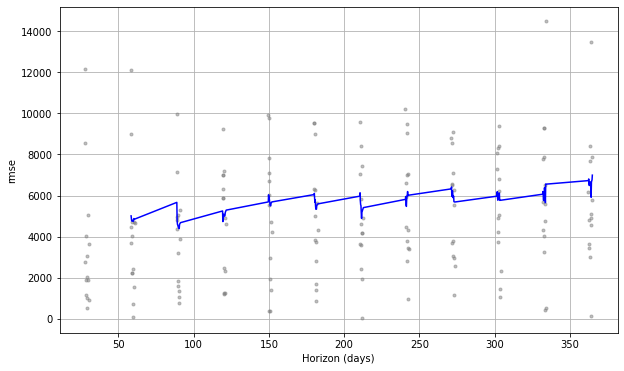

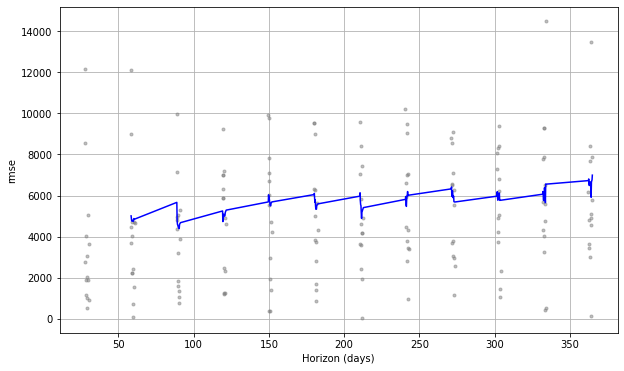

In [ ]:
from fbprophet.plot import plot_cross_validation_metric

plot_cross_validation_metric(df_cv, metric='rmse')


In [ ]:
cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
cutoff = df_cv['cutoff'].unique()[-1]
cutoff

numpy.datetime64('2018-02-01T00:00:00.000000000')

In [ ]:
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

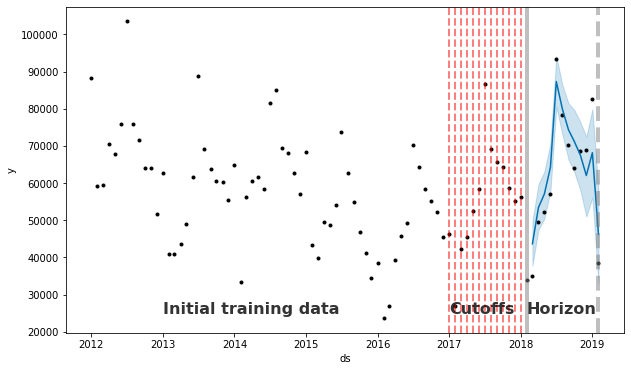

In [ ]:

fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)

ax.plot(model_3.history['ds'].values, model_3.history['y'], 'k.')

ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')

ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)

ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')

# Making all the vlines for cutoffs
for item in cutoffs[:-1]:
  ax.axvline(x=pd.to_datetime(item), c='red', lw=2, alpha=0.5, ls='--')

# Adding text to describe the data set splits
ax.text(x=pd.to_datetime('2013-01-01'),y=25000, s='Initial training data', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.text(x=pd.to_datetime('2017-01-01'),y=25000, s='Cutoffs', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.text(x=pd.to_datetime(cutoff) + pd.Timedelta('0 days'),y=25000, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
           alpha=0.5, ls='--')

# Ajuste de hiperparámetros


In [ ]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df


In [ ]:
def single_cv_run(history_df, metrics, param_dict, parallel):
    m = Prophet(**param_dict)
    # # Adding the extra weather regressors
    # for col in reg_cols:
    #     m.add_regressor(col)
    
    m.fit(history_df)
    df_cv = getCrossValidationData(m)
    df_p = performance_metrics(df_cv, rolling_window=1)
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

In [ ]:
#'changepoint_range': [0.6, 0.7, 0.75, 0.8, 0.9],
#'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.25, 0.5],
#'seasonality_prior_scale':[0.5, 1.0, 2.5, 5],
#'holidays_prior_scale':[1.0, 5.0, 10.0, 15.0],
#'yearly_seasonality':[5, 10, 15, 20],
#'weekly_seasonality':[5, 10, 15, 20],
pd.set_option('display.max_colwidth', None)
param_grid = {                  
                'changepoint_prior_scale': [ 0.5],
                'changepoint_range':  [0.6, 0.7, 0.9],
                'holidays_prior_scale':[1.0, 5.0,  15.0],
                'seasonality_prior_scale':[0.5, 2.5, 5],
                'yearly_seasonality':[5, 10,  20],
              }
metrics = ['horizon', 'rmse', 'mae', 'mape', 'mdape','params'] 
results = []

In [ ]:
import itertools

#Prophet(,)
params_df = create_param_combinations(**param_grid)
params_df

,changepoint_prior_scale,changepoint_range,holidays_prior_scale,seasonality_prior_scale,yearly_seasonality
0,0.5,0.6,1.0,0.5,5
1,0.5,0.6,1.0,0.5,10
2,0.5,0.6,1.0,0.5,20
3,0.5,0.6,1.0,2.5,5
4,0.5,0.6,1.0,2.5,10
5,0.5,0.6,1.0,2.5,20
6,0.5,0.6,1.0,5.0,5
7,0.5,0.6,1.0,5.0,10
8,0.5,0.6,1.0,5.0,20
9,0.5,0.6,5.0,0.5,5


In [ ]:
def getPerfomanceMetrics(m):
  return performance_metrics(getCrossValidationData(m))

def getCrossValidationData(m):
 return cross_validation(m, initial='1825 days', period = '30.4 days', horizon = '365 days')

In [ ]:
# for param in params_df.values:
#     param_dict = dict(zip(params_df.keys(), param))
#     cv_df = single_cv_run(df_train,  metrics, param_dict, parallel="processes")
#     results.append(cv_df)


In [ ]:
# results_df = pd.concat(results).reset_index(drop=True)
# best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
# print(f'\n The best param combination is {best_param.values[0][0]}')
# results_df.mean()

In [ ]:
m = Prophet(changepoint_prior_scale=0.5,
            changepoint_range=0.7,
            seasonality_prior_scale=1.0,
            yearly_seasonality=5,
            seasonality_mode='additive')

# m.add_country_holidays(country_name='BR')
# # Adding the extra weather regressors
# for col in reg_cols:
#     m.add_regressor(col)
    
m.fit(df_train)
getPerfomanceMetrics(m).mean()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 14 forecasts with cutoffs between 2017-01-01 19:12:00 and 2018-02-01 00:00:00


horizon     215 days 04:55:04.918032788
mse                         5.35197e+07
rmse                            7295.82
mae                             6146.21
mape                           0.114801
mdape                         0.0909887
coverage                       0.625768
dtype: object

In [ ]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_train['ds'], y=df_train['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Prediction',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend',))
# fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['rain'], name='Rain',))
# fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['temp'], name='Temp',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yearly'], name='Yearly',))
# fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))


# Add figure title
fig.update_layout(
    template="presentation",
    legend=dict(
        orientation="h",
        yanchor="bottom",   y=1.02,    xanchor="right",    x=1,    
        font=dict(
                family="Georgia",
                size=16),
        bordercolor='white'),
)

fig.show()

In [ ]:
# Make a zero days forecast just for plotting
future = model.make_future_dataframe(periods=df_test.shape[0], freq='M')
future = future.merge(df[reg_cols ], left_index=True, right_index=True)

forecast = m.predict(future)

# Transform back to reality from Box Cox
# forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))
# bikerides['y'] = inv_boxcox(bikerides['y'], lam)

# Plot the results
fig = go.Figure()

upper_bound = go.Scatter(
    name='Upper Bound',
    x=forecast['ds'],
    y=forecast['yhat_upper'],
    mode='lines',
    marker=dict(color="#444"),
    line=dict(width=0),
    fillcolor='#FFECDC',
    fill='tonexty',
    showlegend=False)

trace = go.Scatter(
    name='Prediction',
    x=forecast['ds'],
    y=forecast['yhat'],
    mode='lines',
    line=dict(color='#FF7F0E'),
    fillcolor='#FFECDC',
    fill='tonexty')

lower_bound = go.Scatter(
    name='Lower Bound',
    x=forecast['ds'],
    y=forecast['yhat_lower'],
    marker=dict(color="#444"),
    line=dict(width=0),
    mode='lines',
    showlegend=False)

data = [lower_bound, trace, upper_bound]

fig = go.Figure(data=data)


fig.add_trace(go.Scatter(
    x=df['ds'],
    y=df['y'],
    line_color='#1f77b4',
    name='Actual',
    marker=dict(color="#1f77b4"),

))

fig.add_trace(go.Scatter(
    x=['2019-02-15','2019-02-15'],
    y=[df.y.min(), df.y.max()],
    name = 'General Target',
    line=dict(color='grey', width=3, dash='dot'),
    mode = 'lines',
    showlegend=False),
)


# Add figure title
fig.update_layout(
    template="presentation",
    legend=dict(
        orientation="h",
        yanchor="bottom",   y=1.02,    xanchor="right",    x=1,    
        font=dict(
                family="Georgia",
                size=16),
        bordercolor='white'),
)


fig.show()

In [ ]:
mask2 = forecast['ds'] <= threshold_date

forecast_train = forecast[mask2]
forecast_test = forecast[~ mask2]

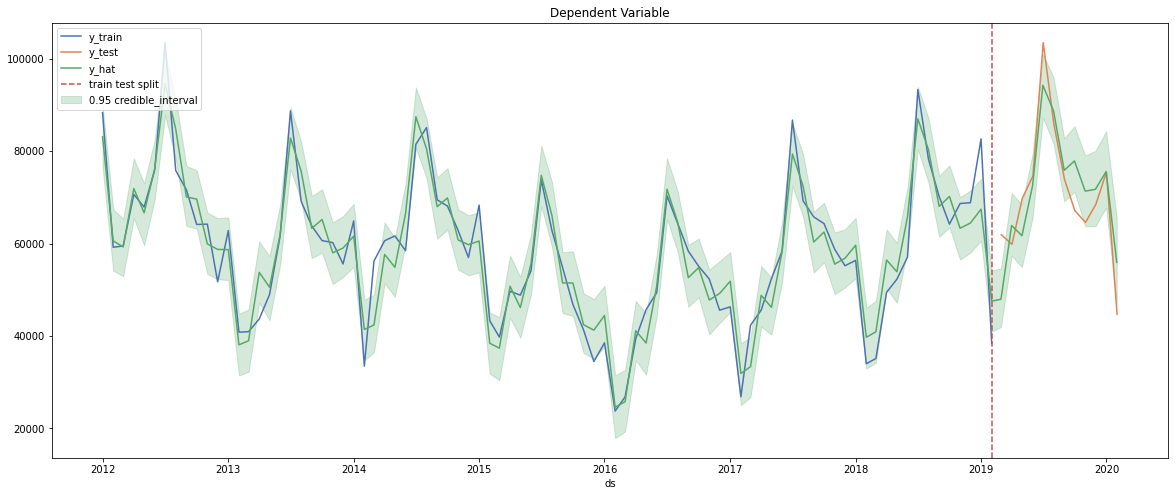

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt

print('r2 train: {}'.format(r2_score(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('r2 test: {}'.format(r2_score(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('---'*10)
print('mae train: {}'.format(mean_absolute_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mae test: {}'.format(mean_absolute_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('mape train: {}'.format(mean_absolute_percentage_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mape test: {}'.format(mean_absolute_percentage_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))


print('RMSE train: {}'.format(sqrt(mean_squared_error(y_true=df_train['y'], y_pred=forecast_train['yhat']))))
print('RMSE test: {}'.format(sqrt(mean_squared_error(y_true=df_test['y'], y_pred=forecast_test['yhat']))))

r2 train: 0.8895503998431541
r2 test: 0.703034433250624
------------------------------
mae train: 4194.208928076094
mae test: 6204.88408681663
mape train: 7.740326061554242
mape test: 9.609020076273035
RMSE train: 5177.600113516359
RMSE test: 7512.61871957426


In [ ]:
forecast_test['yhat']

86    47929.230871
87    63893.772496
88    61692.937454
89    72530.362949
90    94262.204525
91    88725.914895
92    75845.001785
93    77885.839769
94    71350.684383
95    71742.640522
96    75566.326992
97    55918.164179
Name: yhat, dtype: float64